# Bilanciamento del dataset per la classificazione

In questo notebook, esploreremo varie tecniche per gestire dataset sbilanciati per problemi di classificazione. I dataset sbilanciati si verificano quando una classe supera significativamente le altre classi, il che può portare a modelli distorti che hanno prestazioni scadenti sulle classi minoritarie.

In [2]:
# Importa le librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression

# Per il ricampionamento
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 1. Comprensione dello squilibrio di classe

Lo squilibrio di classe si verifica quando una classe (solitamente la classe di maggioranza) ha significativamente più istanze di un'altra classe (la classe di minoranza). Ciò è comune in molti scenari del mondo reale:

- Rilevamento delle frodi (poche transazioni fraudolente tra molte legittime)
- Diagnosi medica (pochi casi positivi tra molti negativi)
- Rilevamento dello spam (e-mail di spam rispetto a e-mail legittime)
- Previsione dell'abbandono (clienti che se ne vanno rispetto a quelli che rimangono)

Problemi con set di dati sbilanciati:
- I modelli tendono ad apprendere una distorsione verso la classe di maggioranza
- Le metriche di accuratezza standard possono essere fuorvianti
- La classe di minoranza, che è spesso la classe di interesse, può essere scarsamente prevista

## 2. Creazione di un set di dati campione non bilanciato

Creiamo un set di dati sintetico non bilanciato con cui lavorare.

Class distribution:
target
0    89591
1    10409
Name: count, dtype: int64
Class 0: 89.59%
Class 1: 10.41%


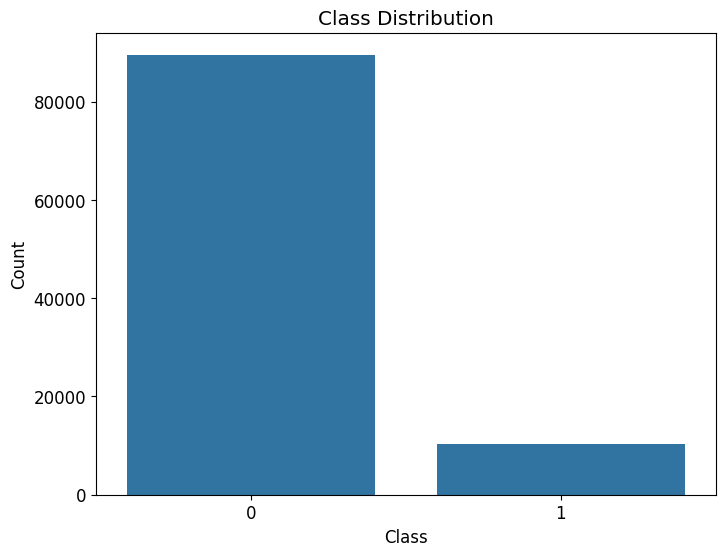

In [3]:
# Crea un set di dati sbilanciato con il 90% di campioni nella classe 0 e il 10% nella classe 1
X, y = make_classification(
    n_samples=100000, 
    n_features=10,
    n_informative=5, 
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[0.9, 0.1],  # Distribuzione delle classi: 90% classe 0, 10% classe 1
    random_state=42
)

# Converti in DataFrame per una manipolazione più semplice
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Controlla la distribuzione delle classi
class_counts = df['target'].value_counts()
print(f"Class distribution:\n{class_counts}")
print(f"Class 0: {class_counts[0] / len(df) * 100:.2f}%")
print(f"Class 1: {class_counts[1] / len(df) * 100:.2f}%")

# Visualizza la distribuzione delle classi
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Probability predictions (for ROC curve)
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Predicted 0', 'Predicted 1'],
               yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    # Plot both curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    ax1.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} - ROC Curve')
    ax1.legend(loc="lower right")
    
    # Precision-Recall Curve
    ax2.plot(recall, precision, label=f'PR curve (area = {pr_auc:.3f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} - Precision-Recall Curve')
    ax2.legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'model': model,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm
    }

#### SPIEGAZIONE CODICE SOPRA
Il codice che hai fornito è una funzione chiamata `evaluate_model`, che serve a **valutare le prestazioni** di un modello di classificazione, in particolare in termini di:

1. **Metriche di classificazione** (come precision, recall, f1-score, ecc.),
2. **Matrice di confusione**,
3. **Curva ROC** (Receiver Operating Characteristic),
4. **Curva Precision-Recall**.

Il codice si occupa di addestrare il modello sui dati di allenamento, fare delle previsioni sui dati di test, e poi calcolare e visualizzare una serie di metriche utili per capire quanto bene il modello sta performando. 

### Ecco cosa fa passo per passo il codice:

#### 1. **Addestramento del Modello**:
   ```python
   model.fit(X_train, y_train)
   ```
   - Il modello viene addestrato sui dati di allenamento (`X_train` e `y_train`).

#### 2. **Previsioni**:
   ```python
   y_pred = model.predict(X_test)
   ```
   - Una volta che il modello è addestrato, viene utilizzato per fare previsioni sui dati di test (`X_test`). Queste previsioni sono memorizzate in `y_pred`.

#### 3. **Previsioni delle probabilità (per ROC curve)**:
   ```python
   if hasattr(model, 'predict_proba'):
       y_prob = model.predict_proba(X_test)[:, 1]
   else:
       y_prob = model.decision_function(X_test)
   ```
   - Se il modello supporta la funzione `predict_proba` (che restituisce le probabilità per ciascuna classe), vengono ottenute le probabilità di previsione per la classe positiva (di solito la classe `1`).
   - Se il modello non supporta `predict_proba`, ma supporta invece la funzione `decision_function` (ad esempio, modelli come SVM), vengono utilizzati i punteggi della funzione decisionale come probabilità (spesso un punteggio di distanza dalla separazione tra le classi).

#### 4. **Classificazione Report**:
   ```python
   print(f"\n{model_name} - Classification Report:")
   print(classification_report(y_test, y_pred))
   ```
   - Viene stampato un **report di classificazione** che include le metriche principali come la **precisione**, il **recall**, l'**F1-score** e l'**accuracy** per ciascuna delle classi.

#### 5. **Matrice di Confusione**:
   ```python
   cm = confusion_matrix(y_test, y_pred)
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Predicted 0', 'Predicted 1'],
               yticklabels=['Actual 0', 'Actual 1'])
   ```
   - Viene calcolata e visualizzata la **matrice di confusione**, che mostra quanti esempi sono stati classificati correttamente e quanti no (vero positivo, falso positivo, vero negativo, falso negativo).
   - La matrice è visualizzata tramite una **heatmap** (mappa di calore), che aiuta a comprendere visivamente il numero di errori commessi.

#### 6. **Curva ROC (Receiver Operating Characteristic)**:
   ```python
   fpr, tpr, _ = roc_curve(y_test, y_prob)
   roc_auc = auc(fpr, tpr)
   ```
   - La **curva ROC** è una rappresentazione grafica che traccia la **tassa di falso positivo (FPR)** sull'asse x e la **tassa di vero positivo (TPR)** sull'asse y.
   - Viene calcolato anche l'**AUC (Area Under the Curve)**, che è una misura dell'abilità del modello di distinguere tra le classi. Un AUC vicino a 1 indica che il modello sta facendo un buon lavoro nel classificare le osservazioni.

#### 7. **Curva Precision-Recall**:
   ```python
   precision, recall, _ = precision_recall_curve(y_test, y_prob)
   pr_auc = average_precision_score(y_test, y_prob)
   ```
   - La **curva Precision-Recall** traccia la **precisione** sull'asse y e il **recall** sull'asse x. Queste metriche sono particolarmente utili quando il dataset è sbilanciato (ad esempio, una classe positiva è rara).
   - Viene calcolato l'**AUC della Precision-Recall Curve**, che misura l'area sotto la curva stessa e fornisce un'indicazione complessiva della performance del modello in presenza di dati sbilanciati.

#### 8. **Visualizzazione delle curve**:
   ```python
   ax1.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
   ax2.plot(recall, precision, label=f'PR curve (area = {pr_auc:.3f})')
   ```
   - Vengono tracciate le **curva ROC** e la **curva Precision-Recall** sui rispettivi assi, con le aree sotto le curve visualizzate nel titolo delle curve.
   - Questi grafici aiutano a visualizzare in modo chiaro come il modello si comporta per differenti valori di soglia.

#### 9. **Restituzione dei Risultati**:
   ```python
   return {
       'model': model,
       'roc_auc': roc_auc,
       'pr_auc': pr_auc,
       'confusion_matrix': cm
   }
   ```
   - Alla fine, la funzione restituisce un dizionario con il **modello**, il **valore AUC della ROC**, il **valore AUC della Precision-Recall** e la **matrice di confusione**. Questi valori possono essere utilizzati per un'analisi successiva o per un confronto tra modelli diversi.

### In sintesi:
Questa funzione è progettata per:
- **Addestrare un modello di classificazione**.
- **Valutare le sue prestazioni** utilizzando diverse metriche importanti (come classificazione report, matrice di confusione, curva ROC e curva Precision-Recall).
- **Visualizzare i risultati** in modo grafico, permettendo di confrontare facilmente le prestazioni del modello.

Se hai bisogno di ulteriori dettagli su come interpretare queste metriche o se vuoi aggiungere qualcosa, fammi sapere!

Suddividiamo i nostri dati in set di addestramento e di test con un approccio stratificato e osserviamo come si comporta un modello di base sul nostro set di dati sbilanciato.

Training set class distribution:
target
0    62714
1     7286
Name: count, dtype: int64
Testing set class distribution:
target
0    26877
1     3123
Name: count, dtype: int64

Baseline (Imbalanced) - Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     26877
           1       0.84      0.67      0.75      3123

    accuracy                           0.95     30000
   macro avg       0.90      0.83      0.86     30000
weighted avg       0.95      0.95      0.95     30000



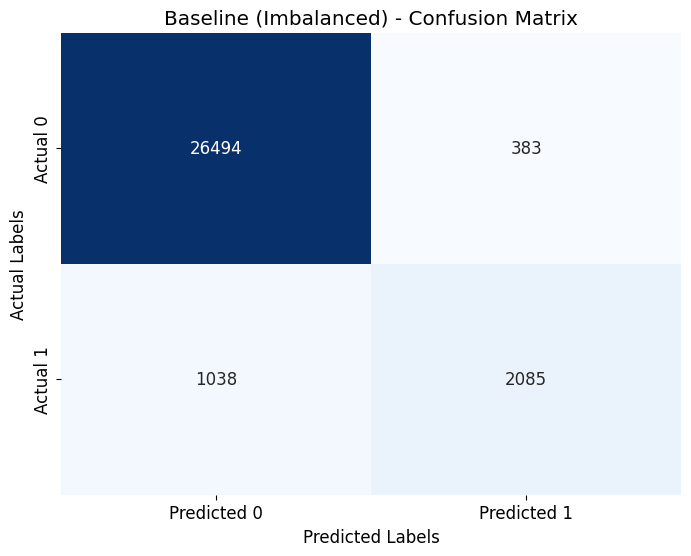

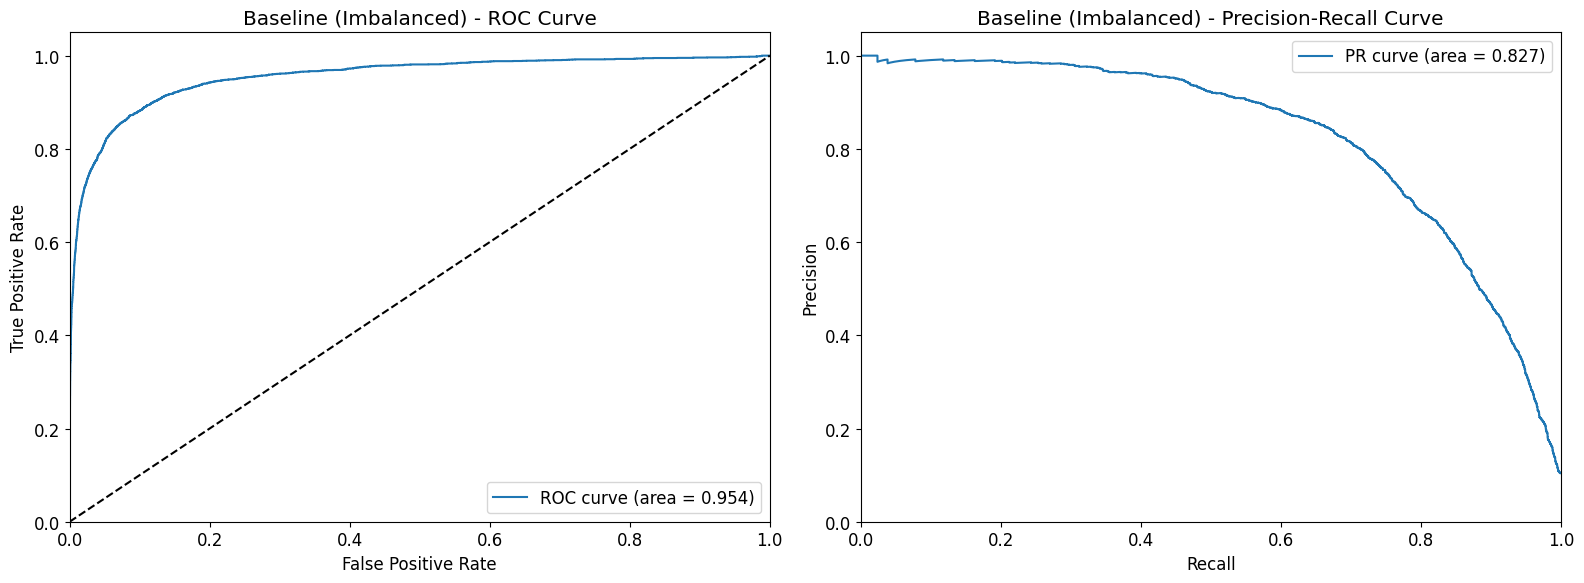

In [5]:
# Dividi i dati
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Controllare la distribuzione delle classi nei set di addestramento e di test
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Testing set class distribution:\n{y_test.value_counts()}")

# Addestrare un modello di regressione logistica di base senza alcun bilanciamento
baseline_model = LogisticRegression(random_state=42)
baseline_results = evaluate_model(baseline_model, X_train, X_test, y_train, y_test, "Baseline (Imbalanced)")

#### SPIEGAZIONE CODICE SOPRA

Questo codice si occupa di preparare i dati, suddividerli in set di addestramento e test, e addestrare un **modello di regressione logistica** di base senza bilanciamento delle classi. Successivamente, viene utilizzato il metodo `evaluate_model` per valutare le prestazioni del modello. Vediamo in dettaglio cosa fa ogni parte del codice:

### 1. **Suddivisione dei dati (train-test split)**:
```python
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
```
- **`X = df.drop('target', axis=1)`**: Questa riga crea una variabile `X` che contiene tutte le caratteristiche (features) del dataframe `df`, tranne la colonna `'target'`, che è la variabile dipendente (la variabile da prevedere).
- **`y = df['target']`**: La variabile `y` contiene solo la colonna `'target'`, che rappresenta le etichette o i valori da prevedere (target).
- **`train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)`**: La funzione `train_test_split` suddivide i dati in un set di addestramento (70% dei dati) e un set di test (30% dei dati). La divisione è fatta in modo casuale, ma il parametro `random_state=42` garantisce che la divisione sia riproducibile. Il parametro `stratify=y` assicura che la distribuzione delle classi in `y` sia mantenuta sia nel set di addestramento che in quello di test (cioè, le proporzioni delle classi nei due set saranno simili).

### 2. **Verifica della distribuzione delle classi nei set di addestramento e test**:
```python
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Testing set class distribution:\n{y_test.value_counts()}")
```
- Queste righe stampano la **distribuzione delle classi** nel set di addestramento (`y_train`) e nel set di test (`y_test`).
- La funzione `value_counts()` conta il numero di occorrenze di ciascuna classe nelle variabili target `y_train` e `y_test`. Questo è utile per verificare se la distribuzione delle classi è bilanciata o meno nei due set.

### 3. **Addestramento del modello di regressione logistica**:
```python
baseline_model = LogisticRegression(random_state=42)
```
- Viene creato un modello di **regressione logistica** chiamato `baseline_model`. Non vengono applicati metodi di bilanciamento delle classi, quindi il modello addestrato sarà sulla base di una distribuzione delle classi così com'è nei dati originali (potenzialmente sbilanciata).

### 4. **Valutazione del modello (senza bilanciamento delle classi)**:
```python
baseline_results = evaluate_model(baseline_model, X_train, X_test, y_train, y_test, "Baseline (Imbalanced)")
```
- Qui il modello di regressione logistica viene addestrato utilizzando il metodo `fit` sui dati di addestramento (`X_train` e `y_train`) e quindi le sue prestazioni vengono valutate utilizzando la funzione `evaluate_model` sui dati di test (`X_test` e `y_test`).
- Il parametro `"Baseline (Imbalanced)"` è un'etichetta che viene utilizzata nel nome del modello per distinguerlo da altri modelli che potrebbero essere addestrati con tecniche di bilanciamento delle classi.
- La funzione `evaluate_model` restituisce un'analisi delle prestazioni del modello, comprese le metriche di classificazione, la matrice di confusione, la curva ROC e la curva Precision-Recall.

### In sintesi:
- **Suddivisione dei dati**: i dati vengono suddivisi in set di addestramento e test, mantenendo la distribuzione delle classi tramite `stratify=y`.
- **Verifica distribuzione delle classi**: viene verificato se le classi nel set di addestramento e di test sono bilanciate o sbilanciate.
- **Addestramento del modello**: viene creato un modello di regressione logistica e addestrato senza alcun bilanciamento delle classi.
- **Valutazione delle prestazioni**: viene valutato il modello addestrato e vengono visualizzate varie metriche (come precisione, recall, F1-score, curva ROC, e precision-recall curve).

Se il modello è sbilanciato, i risultati potrebbero non essere ottimali, in particolare se una classe è molto meno rappresentata rispetto all'altra. In tal caso, si potrebbe considerare di applicare tecniche di **bilanciamento delle classi** (ad esempio, **oversampling**, **undersampling**, o l'uso di modelli come **SMOTE**) per migliorare le prestazioni del modello.

## 3. Tecniche di ricampionamento

### 3.1 Sottocampionamento

Il sottocampionamento riduce il numero di istanze nella classe di maggioranza per adattarle alla classe di minoranza. Ciò può aiutare a bilanciare il set di dati, ma può portare alla perdita di informazioni.

Il **sottocampionamento** è una tecnica di **bilanciamento del dataset** che viene utilizzata quando il dataset è sbilanciato, ossia quando una classe (ad esempio, la classe positiva in un problema di classificazione binaria) è rappresentata da molte più istanze rispetto all'altra classe (la classe negativa). L'obiettivo del sottocampionamento è ridurre la classe di maggioranza in modo che le due classi siano più equilibrate. 

Questa tecnica può essere utile per evitare che un modello diventi **predittivamente sbilanciato**, ossia che predica sempre la classe maggioritaria a causa della sua prevalenza nel dataset, ma ha anche alcuni svantaggi. Vediamo in dettaglio come funziona, i suoi vantaggi e svantaggi.

### Come funziona il sottocampionamento

1. **Identificazione delle classi sbilanciate**:
   Prima di applicare il sottocampionamento, bisogna determinare se le classi sono sbilanciate. Un dataset sbilanciato è quando una delle classi ha una rappresentazione significativamente più alta rispetto all'altra. Ad esempio, in un dataset di **fraud detection**, la classe che rappresenta le transazioni fraudolente potrebbe essere di gran lunga inferiore alla classe delle transazioni non fraudolente.

2. **Riduzione delle istanze della classe maggioritaria**:
   Il sottocampionamento riduce il numero di istanze della classe di maggioranza. In pratica, si selezionano solo una parte delle istanze della classe di maggioranza per ridurre il suo numero fino ad arrivare a un livello simile a quello della classe di minoranza. Questo può essere fatto in vari modi:
   
   - **Campionamento casuale**: Si selezionano casualmente un numero fisso di campioni dalla classe maggioritaria.
   - **Campionamento basato su strategie intelligenti**: Invece di selezionare campioni in modo completamente casuale, si usano tecniche che cercano di mantenere campioni rappresentativi della classe maggioritaria, per evitare di perdere troppo in termini di variabilità.

3. **Creazione di un dataset bilanciato**:
   Dopo aver ridotto il numero di istanze della classe di maggioranza, il dataset risultante avrà una distribuzione più equilibrata tra le classi. Questo può migliorare le performance del modello, poiché il modello non sarà più "sbilanciato" verso la classe maggioritaria.

### Vantaggi del sottocampionamento
- **Riduzione del rischio di overfitting**: Poiché il sottocampionamento riduce il numero di dati, può aiutare a prevenire il problema dell'overfitting (quando il modello diventa troppo complesso e si adatta troppo ai dati di addestramento, non generalizzando bene sui dati di test).
- **Miglioramento della performance del modello**: In alcuni casi, un dataset bilanciato può migliorare le metriche di classificazione, poiché il modello non sarà incline a fare previsioni di classe maggioritaria in modo sproporzionato.
- **Semplicità**: È una tecnica relativamente semplice da implementare e non richiede molta complessità computazionale rispetto ad altre tecniche di bilanciamento.

### Svantaggi del sottocampionamento
- **Perdita di informazioni**: La principale preoccupazione con il sottocampionamento è che ridurre il numero di istanze della classe maggioritaria può comportare una perdita di informazioni preziose. Potresti eliminare dati che potrebbero contenere informazioni importanti per migliorare la capacità predittiva del modello.
- **Non garantisce un miglioramento delle prestazioni**: Sebbene il sottocampionamento possa bilanciare le classi, non è detto che migliorerà sempre le prestazioni del modello. In alcuni casi, potrebbe addirittura peggiorare le prestazioni, specialmente se vengono rimosse molte istanze significative.
- **Bias**: Se il sottocampionamento non viene fatto correttamente (ad esempio, se si rimuovono campioni in modo casuale senza considerare la loro importanza), potrebbe introdurre un **bias** nel modello. Il modello potrebbe non essere in grado di apprendere correttamente la distribuzione naturale dei dati.

### Metodi di sottocampionamento

1. **Random Under-Sampling (RUS)**:
   Il **Random Under-Sampling** è la tecnica di sottocampionamento più semplice. Essa seleziona casualmente un numero di esempi dalla classe di maggioranza in modo che il numero di esempi in entrambe le classi sia lo stesso o simile. Tuttavia, questo approccio può essere inefficiente, in quanto non tiene conto della distribuzione e della variabilità dei dati.

2. **Tomek Links**:
   I **Tomek Links** sono coppie di campioni da classi diverse che sono vicini tra loro. Il sottocampionamento basato su Tomek Links consiste nel rimuovere i campioni della classe maggioritaria che sono troppo vicini ai campioni della classe di minoranza, in modo da "pulisce" il dataset da possibili rumori.

3. **Condensed Nearest Neighbour (CNN)**:
   Questo metodo mira a mantenere un sottoinsieme di dati che è rappresentativo della classe di maggioranza e che può distinguere chiaramente tra le due classi. Se il campione della classe maggioritaria è molto simile a quello della classe minoritaria, verrà rimosso.

4. **Cluster Centroids**:
   Un altro approccio più sofisticato è utilizzare il clustering (ad esempio, k-means) per creare **centroidi** che rappresentano la classe di maggioranza, riducendo il numero di campioni mantenendo però una buona rappresentazione della classe. In pratica, il metodo crea centri rappresentativi per i dati della classe maggioritaria, riducendo la variabilità senza perdere troppe informazioni.

### Quando usare il sottocampionamento

Il sottocampionamento è utile quando:
- Il dataset è estremamente sbilanciato, e la classe di minoranza è molto piccola.
- Si desidera ridurre la complessità computazionale (ad esempio, in situazioni in cui si ha una grande quantità di dati della classe maggioritaria).
- Si ha un dataset di dimensioni relativamente piccole e non si vuole perdere molte istanze dalla classe di minoranza.
  
### Alternative al sottocampionamento

- **Sovracampionamento (Oversampling)**: Invece di ridurre il numero di campioni nella classe maggioritaria, si può aumentare il numero di campioni nella classe minoritaria. Una tecnica popolare di sovracampionamento è il **SMOTE** (Synthetic Minority Over-sampling Technique), che genera nuovi esempi sintetici per la classe minoritaria.
  
- **Tecniche ibride**: Combinare sia il sottocampionamento che il sovracampionamento per cercare di bilanciare il dataset senza compromettere troppe informazioni. Ad esempio, si potrebbe sottocampionare la classe maggioritaria, ma anche sovracampionare la classe minoritaria.

### In sintesi

Il sottocampionamento è una tecnica utile per bilanciare i dataset sbilanciati, ma deve essere utilizzato con attenzione poiché può comportare una perdita di informazioni e una riduzione della variabilità dei dati. È importante scegliere la tecnica di sottocampionamento giusta, valutando se la riduzione dei dati porta a miglioramenti nelle prestazioni del modello o se la perdita di informazioni risulta controproducente.

After undersampling - Training set class distribution:
target
0    7286
1    7286
Name: count, dtype: int64

Undersampling - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     26877
           1       0.50      0.90      0.64      3123

    accuracy                           0.90     30000
   macro avg       0.74      0.90      0.79     30000
weighted avg       0.94      0.90      0.91     30000



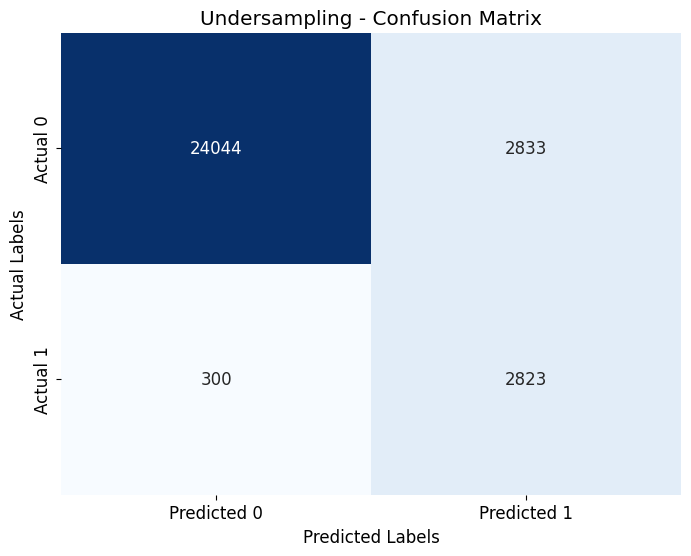

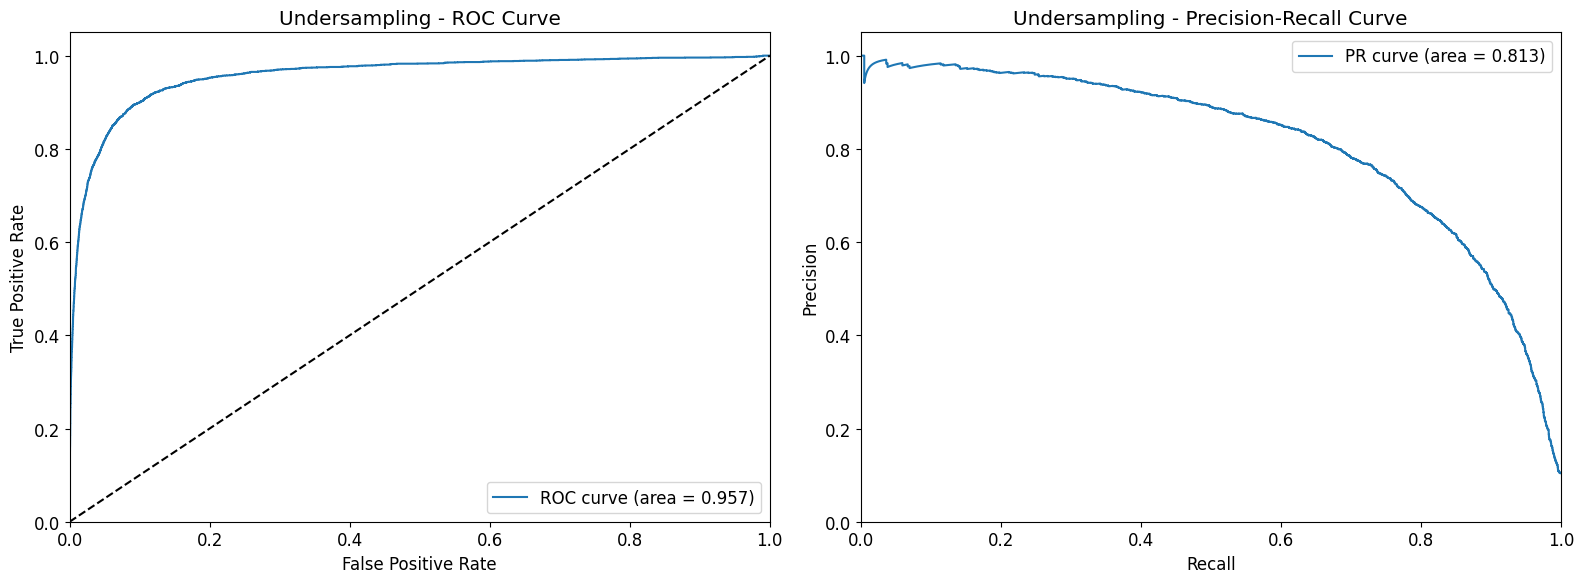

In [6]:
# Applica il sottocampionamento casuale
undersampler = RandomUnderSampler(random_state=42) #, sampling_strategy={0: 14000, 1: 7286}
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Controlla la nuova distribuzione delle classi
print(f"After undersampling - Training set class distribution:\n{pd.Series(y_train_under).value_counts()}")

#Addestrare un modello sui dati sottocampionati
undersample_model = LogisticRegression(random_state=42)
undersample_results = evaluate_model(undersample_model, X_train_under, X_test, y_train_under, y_test, "Undersampling")

### 3.2 Sovracampionamento

Il sovracampionamento aumenta il numero di istanze nella classe di minoranza duplicando i campioni esistenti. Ciò preserva tutte le informazioni della classe di maggioranza ma può portare a un sovraadattamento.

Il **sovracampionamento** (o **oversampling**) è una tecnica di **bilanciamento dei dati** che mira a risolvere il problema dei dataset sbilanciati, in cui una classe (la classe di minoranza) ha meno campioni rispetto a un'altra classe (la classe di maggioranza). A differenza del **sottocampionamento**, che riduce il numero di esempi nella classe di maggioranza, il sovracampionamento aumenta il numero di esempi nella classe di minoranza.

### Come funziona il sovracampionamento

Il sovracampionamento si basa sull'idea di **aumentare artificialmente la dimensione della classe di minoranza**. In pratica, il numero di esempi della classe di minoranza viene aumentato duplicando i campioni esistenti o generando nuovi campioni sintetici.

Esistono due approcci principali al sovracampionamento:
1. **Duplicazione dei campioni esistenti**.
2. **Generazione di nuovi campioni sintetici** (ad esempio, tramite **SMOTE**, Synthetic Minority Over-sampling Technique).

### 1. Duplicazione dei campioni esistenti
In questo caso, il sovracampionamento avviene semplicemente **duplicando i campioni** della classe di minoranza fino a raggiungere un numero simile a quello della classe di maggioranza. Sebbene questo approccio sia semplice e facile da implementare, ha alcuni svantaggi:
- **Rischio di sovraadattamento**: Duplicando campioni esistenti, si rischia di fare in modo che il modello "impari troppo bene" i dati della classe minoritaria, portando a un fenomeno di **overfitting**. In altre parole, il modello potrebbe imparare a memorizzare i campioni duplicati, senza generalizzare correttamente a nuovi dati.
- **Scarsa varietà dei dati**: Duplicare semplicemente i campioni non porta nuova informazione, quindi il modello non impara a generalizzare meglio, ma solo a riconoscere ripetutamente gli stessi esempi.

### 2. Generazione di campioni sintetici (SMOTE)
Una tecnica più avanzata è il **SMOTE** (Synthetic Minority Over-sampling Technique), che crea nuovi esempi sintetici invece di duplicare semplicemente quelli esistenti. SMOTE funziona come segue:

1. **Selezione di un esempio dalla classe di minoranza**: Per ogni esempio della classe di minoranza, SMOTE trova i suoi vicini più prossimi (in base a una distanza come la distanza euclidea).
2. **Creazione di nuovi campioni sintetici**: A partire da un esempio, SMOTE genera nuovi campioni interpolando i dati. La sintesi avviene prendendo un punto casuale lungo la linea che connette l'esempio selezionato e uno dei suoi vicini più prossimi. I nuovi punti sono generati in modo che il modello possa "imparare" non solo dai dati originali, ma anche da varianti di questi esempi.
   
Questa tecnica aiuta a ridurre il rischio di sovraadattamento, poiché i nuovi esempi sintetici aggiungono **varietà** al dataset e non sono duplicati esatti degli esempi già esistenti.

### Vantaggi del sovracampionamento

1. **Aumento della rappresentatività della classe di minoranza**:
   Aumentando la dimensione della classe di minoranza, il modello ha più opportunità di apprendere le caratteristiche di quella classe. Questo aiuta a migliorare la capacità del modello di identificare correttamente la classe di minoranza.

2. **Miglioramento delle metriche di valutazione**:
   Il sovracampionamento può migliorare le prestazioni del modello in termini di **accuratezza**, **precisione**, **richiamo** e **F1-score** per la classe di minoranza, poiché il modello non sarà più sbilanciato verso la classe di maggioranza.

3. **Tecniche avanzate come SMOTE riducono il rischio di overfitting**:
   Rispetto alla semplice duplicazione dei campioni, SMOTE e altre tecniche di sovracampionamento basate su generazione di dati sintetici riducono il rischio di sovraadattamento, poiché i campioni sintetici non sono copie esatte dei dati esistenti.

### Svantaggi del sovracampionamento

1. **Sovraadattamento (Overfitting)**:
   Sebbene SMOTE aiuti a ridurre il rischio di sovraadattamento rispetto alla duplicazione dei campioni, **il rischio di overfitting** è comunque presente. Il modello potrebbe imparare troppo bene a riconoscere la classe di minoranza (anche dai nuovi campioni sintetici), e potrebbe non generalizzare correttamente ai dati futuri.

2. **Aumento della complessità computazionale**:
   Il sovracampionamento, in particolare il processo di generazione di nuovi campioni tramite SMOTE, può aumentare significativamente la **complessità computazionale**. SMOTE richiede calcoli per determinare i vicini più prossimi, quindi potrebbe essere più lento di altre tecniche di bilanciamento dei dati.

3. **Introduzione di rumore**:
   Se i dati della classe di minoranza sono particolarmente rumorosi o se la generazione di campioni sintetici non è ben controllata, i nuovi campioni sintetici potrebbero introdurre **rumore** nel dataset, peggiorando la capacità del modello di fare previsioni accurate.

4. **Difficoltà con variabili categoriche**:
   SMOTE funziona bene con variabili numeriche, ma con variabili categoriche (ad esempio, variabili qualitative come il sesso o il tipo di prodotto), la sintesi di nuovi campioni può essere complessa. Esistono alcune varianti di SMOTE che cercano di trattare variabili categoriche, ma in generale SMOTE è più adatto per variabili numeriche.


### Quando usare il sovracampionamento

Il sovracampionamento è utile quando:
- **La classe di minoranza è significativa**: Quando la classe di minoranza contiene esempi importanti e si desidera evitare di perdere informazioni da quella classe.
- **Il dataset è molto sbilanciato**: Quando la classe di minoranza ha pochi esempi e il modello tende a predire sempre la classe di maggioranza.
- **Si vuole ridurre il rischio di overfitting tramite SMOTE**: Quando si vuole bilanciare le classi senza duplicare i campioni esistenti, ma mantenendo varietà nei dati.

### In sintesi

Il sovracampionamento è una tecnica potente per bilanciare dataset sbilanciati, in particolare quando la classe di minoranza è significativa. Tuttavia, richiede cautela, poiché può portare a **sovraadattamento**, **aumento della complessità computazionale** e **introduzione di rumore**. L'approccio più sofisticato, come SMOTE e le sue varianti, è generalmente preferito rispetto alla semplice duplicazione dei campioni, in quanto aiuta a migliorare la generalizzazione del modello e a evitare l'overfitting.

After oversampling - Training set class distribution:
target
0    62714
1    62714
Name: count, dtype: int64

Oversampling - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     26877
           1       0.50      0.91      0.64      3123

    accuracy                           0.89     30000
   macro avg       0.74      0.90      0.79     30000
weighted avg       0.94      0.89      0.91     30000



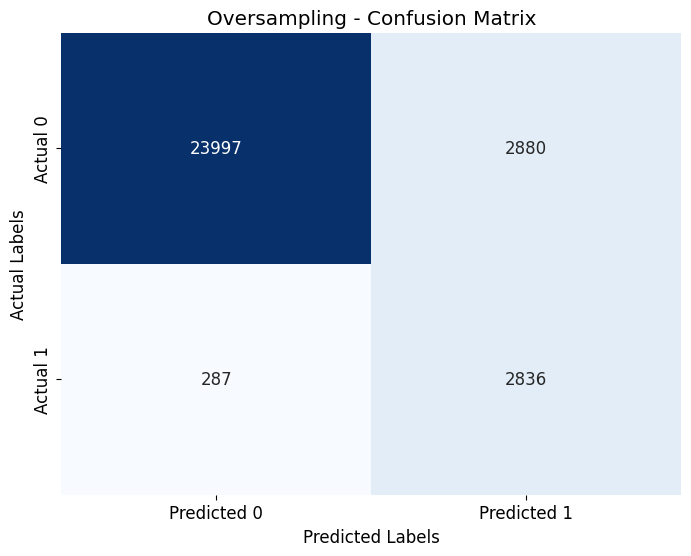

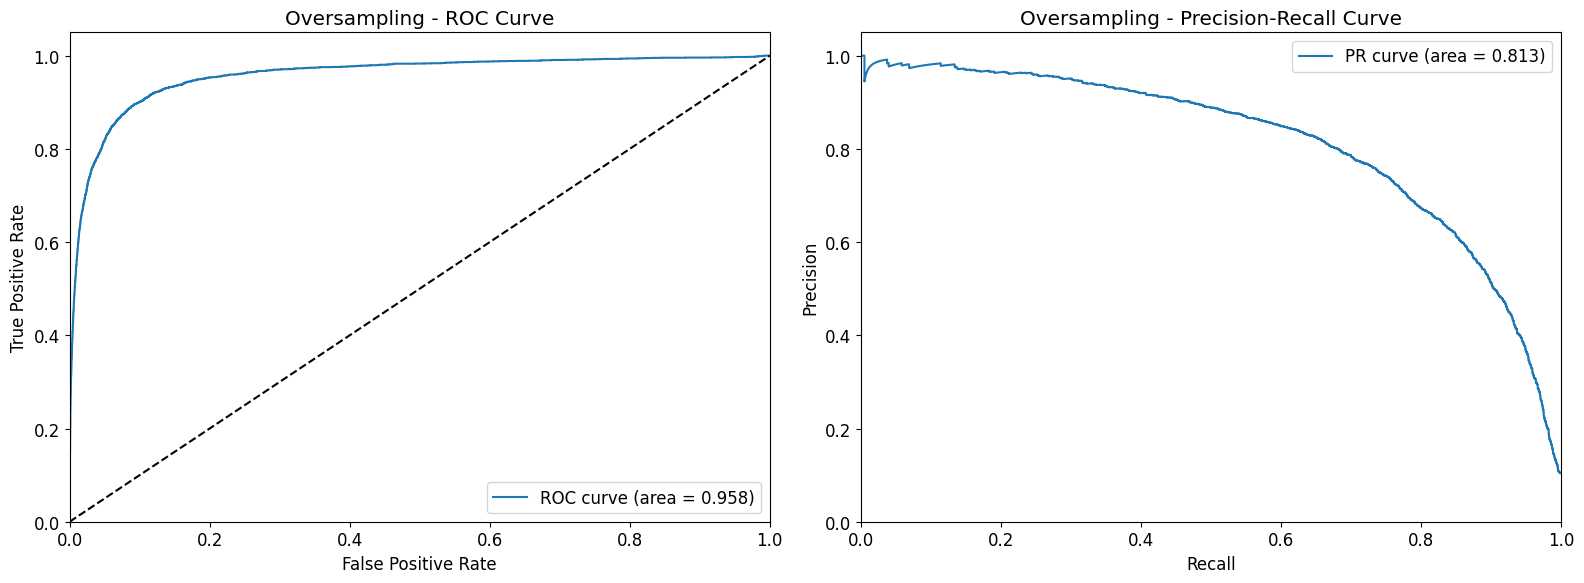

In [7]:
# Applicare il sovracampionamento casuale
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Controlla la nuova distribuzione delle classi
print(f"After oversampling - Training set class distribution:\n{pd.Series(y_train_over).value_counts()}")

# Addestrare un modello sui dati sovracampionati
oversample_model = LogisticRegression(random_state=42)
oversample_results = evaluate_model(oversample_model, X_train_over, X_test, y_train_over, y_test, "Oversampling")

### SPIEGAZIONE CODICE SOPRA
Certo! Questo codice applica una tecnica di **sovracampionamento** ai dati di addestramento, per bilanciare un dataset sbilanciato, e poi allena un modello di regressione logistica sui dati sovracampionati. Vediamo il flusso di questo codice passo per passo:

### 1. **Applicazione del sovracampionamento casuale**
```python
oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)
```
In questa parte:
- **`RandomOverSampler`** è una classe del modulo `imblearn` (una libreria Python per il bilanciamento dei dataset sbilanciati). Questo strumento applica il sovracampionamento casuale.
- **`fit_resample()`** è il metodo utilizzato per **applicare il sovracampionamento** al dataset. Questo metodo prende i dati di addestramento (`X_train` e `y_train`) e **genera nuovi campioni sintetici** della classe minoritaria per bilanciare la distribuzione delle classi.
  - **`X_train`** è il set di caratteristiche (caratteristiche delle istanze di addestramento).
  - **`y_train`** è l'etichetta o la variabile target per le istanze di addestramento.
- **`random_state=42`** è utilizzato per fissare il seme (seed) del generatore di numeri casuali, assicurando che il processo di sovracampionamento sia riproducibile.

Il risultato di questa operazione sono i dati sovracampionati: `X_train_over` (le caratteristiche del training set bilanciato) e `y_train_over` (le etichette del training set bilanciato).

### 2. **Controllo della nuova distribuzione delle classi**
```python
print(f"After oversampling - Training set class distribution:\n{pd.Series(y_train_over).value_counts()}")
```
- Qui si controlla la **distribuzione delle classi** nel set di addestramento dopo il sovracampionamento. La funzione `value_counts()` conta quante istanze ci sono per ogni classe nel target (`y_train_over`), che ora dovrebbe essere bilanciato.
  - Se il dataset originale aveva una **classe di minoranza** con pochi esempi, dopo il sovracampionamento la classe di minoranza avrà lo stesso numero di esempi della classe di maggioranza.

### 3. **Allenamento di un modello con i dati sovracampionati**
```python
oversample_model = LogisticRegression(random_state=42)
oversample_results = evaluate_model(oversample_model, X_train_over, X_test, y_train_over, y_test, "Oversampling")
```
- **`LogisticRegression(random_state=42)`** crea un modello di **regressione logistica**, che è un modello di classificazione utilizzato per predire una variabile target binaria.
- Questo modello viene poi allenato sui dati sovracampionati (`X_train_over` e `y_train_over`), mentre il set di test (`X_test` e `y_test`) rimane invariato (non viene sovracampionata la parte di test per mantenere l'integrità del processo di valutazione).
  
  La funzione `evaluate_model()` che viene chiamata qui è responsabile di:
  - **Allenare il modello** sulla base dei dati sovracampionati (`X_train_over` e `y_train_over`).
  - **Effettuare previsioni** sui dati di test.
  - **Valutare le prestazioni del modello** utilizzando metriche come la matrice di confusione, il report di classificazione, la curva ROC e la curva precision-recall.

### In sintesi:
1. **Sovracampionamento**: La tecnica di sovracampionamento è utilizzata per bilanciare il dataset di addestramento, in modo che ci siano lo stesso numero di esempi per ogni classe.
2. **Allenamento**: Un modello di regressione logistica viene allenato sui dati bilanciati.
3. **Valutazione**: Vengono calcolate e visualizzate le metriche di performance per confrontare il modello sovracampionamento con gli altri modelli.

Il principale vantaggio di questa tecnica è che permette al modello di imparare meglio dalla classe di minoranza, riducendo il rischio di **bias verso la classe di maggioranza**. Tuttavia, bisogna fare attenzione a non introdurre **overfitting** sui dati sovracampionati, in quanto questi campioni sintetici potrebbero far "memorizzare" troppo bene il modello sugli esempi della minoranza.

### 3.3 SMOTE (tecnica di sovracampionamento di minoranza sintetica)

SMOTE genera campioni sintetici per la classe di minoranza mediante interpolazione tra campioni di minoranza esistenti. Ciò riduce l'overfitting rispetto al semplice sovracampionamento.

SMOTE, che sta per **Synthetic Minority Over-sampling Technique**, è una tecnica avanzata di **sovracampionamento** utilizzata per bilanciare un dataset sbilanciato, riducendo il rischio di **overfitting** che può verificarsi quando si utilizzano semplici metodi di sovracampionamento (come la duplicazione dei campioni della classe minoritaria). Invece di duplicare semplicemente le osservazioni della classe minoritaria, SMOTE crea nuovi campioni **sintetici** combinando gli esempi esistenti.

Ecco come funziona il processo di SMOTE:

### Come funziona SMOTE?

1. **Selezione di un campione minoritario**:
   SMOTE inizia selezionando un campione casuale dalla classe minoritaria (la classe con meno esempi nel dataset).

2. **Trova i vicini più prossimi (K-nearest neighbors, KNN)**:
   Per ogni campione della classe minoritaria, SMOTE trova i **K vicini più prossimi** (solitamente K=5) di quel campione all'interno della stessa classe. Questo viene fatto utilizzando una misura di distanza come la distanza euclidea.

3. **Generazione dei campioni sintetici**:
   Una volta identificati i vicini, SMOTE crea nuovi campioni sintetici **interpolando tra il campione selezionato e i suoi vicini**. La formula di interpolazione è la seguente:

   $$ x_{\text{new}} = x_{\text{sample}} + \lambda \cdot (x_{\text{neighbor}} - x_{\text{sample}}) $$

   dove:
   - \( x_{\text{new}} \) è il nuovo campione sintetico creato,
   - \( x_{\text{sample}} \) è il campione della classe minoritaria selezionato,
   - \( x_{\text{neighbor}} \) è un vicino di \( x_{\text{sample}} \),
   - \( \lambda \) è un valore casuale tra 0 e 1, che permette di generare campioni nuovi in diverse posizioni tra il campione selezionato e il vicino.

4. **Ripetizione**:
   Questo processo viene ripetuto per ogni campione della classe minoritaria fino a raggiungere il numero desiderato di campioni sintetici.

### Vantaggi di SMOTE
- **Riduzione dell'overfitting**: Poiché SMOTE genera nuovi campioni sintetici piuttosto che duplicare quelli esistenti, il rischio di **overfitting** (adattamento eccessivo sui dati minoritari) viene ridotto. I nuovi campioni non sono identici a quelli già esistenti, ma sono una **combinazione** di quelli esistenti.
  
- **Miglioramento della generalizzazione**: Poiché i campioni sintetici sono una "media" dei campioni esistenti, il modello può apprendere meglio la **distribuzione della classe minoritaria** e migliorare la sua capacità di generalizzare su nuovi dati.

- **Equilibrio tra le classi**: SMOTE aiuta a bilanciare il dataset, dandogli **più equità tra le classi** e quindi riducendo il rischio che il modello tenda a favorire la classe maggioritaria.

### Svantaggi di SMOTE
- **Introduzione di rumore**: Poiché SMOTE genera nuovi campioni basati su una combinazione di punti esistenti, può introdurre **rumore** nei dati se i punti esistenti sono molto disomogenei o mal etichettati. Ciò potrebbe comportare la generazione di campioni che non sono rappresentativi della classe minoritaria.

- **Overfitting sui dati sintetici**: Sebbene SMOTE riduca l'overfitting rispetto al sovracampionamento semplice, esiste comunque il rischio che il modello si adatti troppo strettamente ai campioni sintetici, specialmente se il numero di vicini selezionati è troppo alto o i campioni originali sono troppo simili tra loro.

- **Complessità computazionale**: SMOTE richiede più calcoli rispetto al semplice sovracampionamento, in quanto deve trovare i vicini più prossimi e generare i nuovi campioni sintetici per ogni esempio della classe minoritaria.

### In sintesi:
- **SMOTE** è una tecnica avanzata di **sovracampionamento** che crea campioni sintetici per la classe minoritaria basati su interpolazioni tra campioni esistenti.
- Aiuta a bilanciare i dataset sbilanciati riducendo il rischio di **overfitting** rispetto al semplice sovracampionamento, che tende a duplicare campioni esistenti.
- Sebbene SMOTE riduca l'overfitting rispetto al sovracampionamento semplice, potrebbe comunque introdurre rumore se i dati originali sono disomogenei o se i parametri non sono scelti correttamente.

SMOTE è particolarmente utile quando le classi sono sbilanciate, come nei problemi di **classificazione delle frodi** o in altri scenari in cui la classe di minoranza è più rara ma altrettanto importante.

After SMOTE - Training set class distribution:
target
0    62714
1    62714
Name: count, dtype: int64

SMOTE - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     26877
           1       0.50      0.90      0.65      3123

    accuracy                           0.90     30000
   macro avg       0.75      0.90      0.79     30000
weighted avg       0.94      0.90      0.91     30000



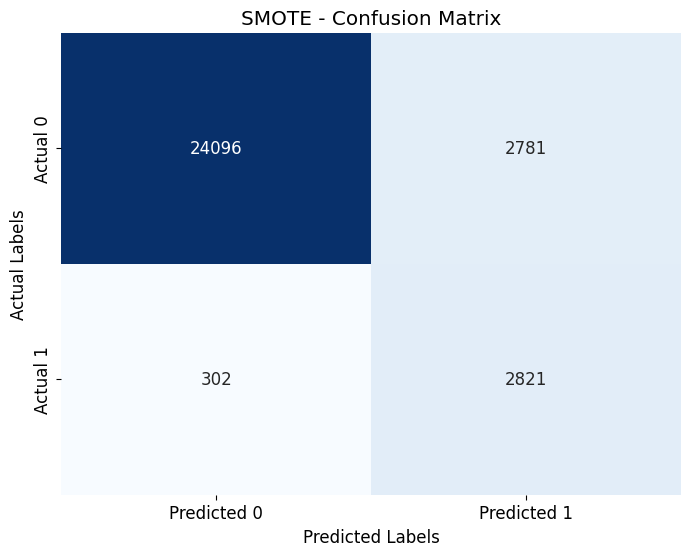

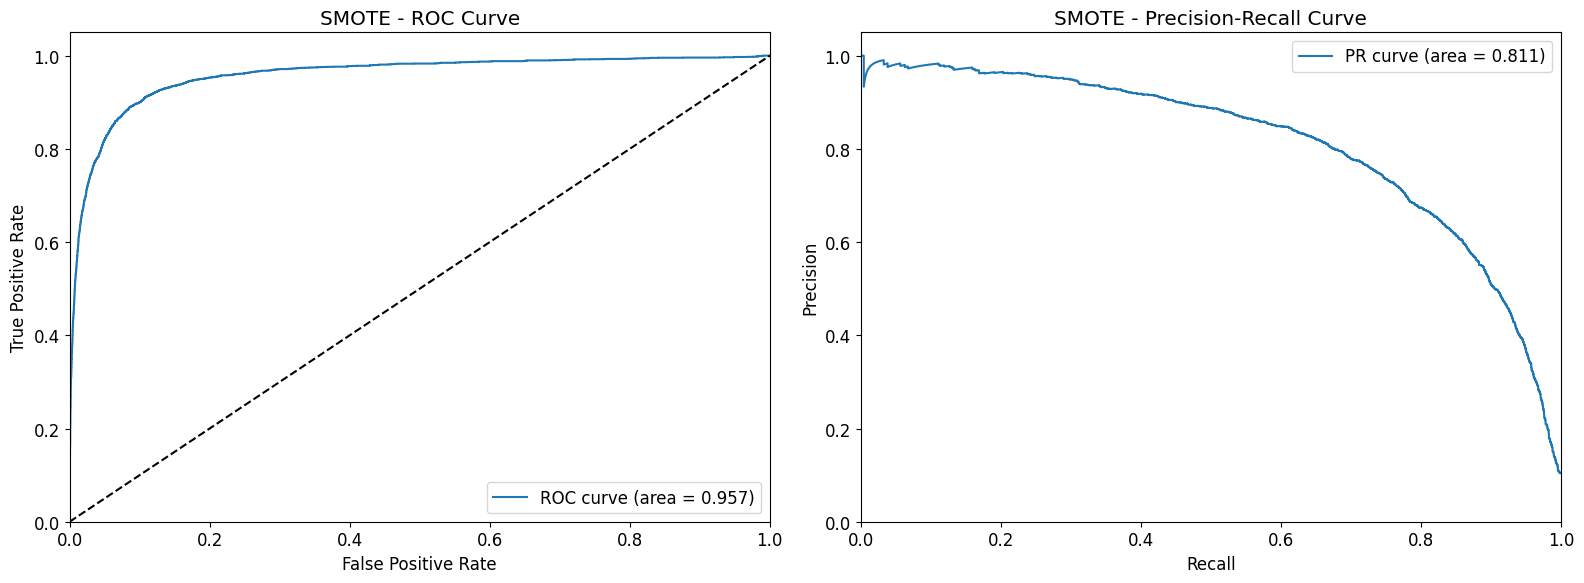

In [8]:
# Applica SMOTE
smote = SMOTE(random_state=42,)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Controlla la nuova distribuzione delle classi
print(f"After SMOTE - Training set class distribution:\n{pd.Series(y_train_smote).value_counts()}")

# Addestrare un modello sui dati SMOTE
smote_model = LogisticRegression(random_state=42)
smote_results = evaluate_model(smote_model, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")

### SPIEGAZIONE CODICE SOPRA

Questo codice applica la tecnica **SMOTE (Synthetic Minority Over-sampling Technique)** al tuo dataset per bilanciare le classi, quindi allena un modello di **regressione logistica** sui dati bilanciati e valuta il modello. Ecco una spiegazione passo passo di cosa fa il codice:

### 1. Applicazione di SMOTE per il sovracampionamento
```python
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
```
- **SMOTE(random_state=42)**: Crea un oggetto SMOTE che utilizza il seme casuale 42 (per garantire che i risultati siano riproducibili). SMOTE è una tecnica di **sovracampionamento** che genera nuovi campioni sintetici per la classe minoritaria.
- **smote.fit_resample(X_train, y_train)**: A questo punto, SMOTE applica la tecnica al tuo **dataset di addestramento** (`X_train` e `y_train`). In particolare, genera nuovi campioni sintetici per la classe minoritaria (di solito la classe con meno esempi), e restituisce i nuovi set di dati **sovracampionati**: `X_train_smote` (caratteristiche) e `y_train_smote` (etichette).

### 2. Verifica della nuova distribuzione delle classi dopo l'applicazione di SMOTE
```python
print(f"After SMOTE - Training set class distribution:\n{pd.Series(y_train_smote).value_counts()}")
```
- Questo comando stampa la distribuzione delle classi nel **dataset di addestramento bilanciato** (`y_train_smote`). `value_counts()` restituisce il numero di campioni in ogni classe, quindi puoi vedere se SMOTE ha bilanciato correttamente le due classi. L'output dovrebbe mostrare che la classe minoritaria ha ora lo stesso numero di esempi della classe maggioritaria (o almeno un numero molto vicino).

### 3. Addestramento del modello di regressione logistica sui dati bilanciati
```python
smote_model = LogisticRegression(random_state=42)
smote_results = evaluate_model(smote_model, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")
```
- **LogisticRegression(random_state=42)**: Crea un oggetto del modello di **regressione logistica**, che è un modello di classificazione. Il parametro `random_state=42` garantisce che il processo di allenamento sia riproducibile.
- **evaluate_model(smote_model, X_train_smote, X_test, y_train_smote, y_test, "SMOTE")**: Qui, il modello di regressione logistica (definito in `smote_model`) viene addestrato sui dati di addestramento **bilanciati** (X_train_smote, y_train_smote) e quindi valutato sul set di test (X_test, y_test). La funzione `evaluate_model()` probabilmente restituisce varie metriche di performance del modello, come la **matrice di confusione**, il **punteggio di accuratezza**, e le **curve ROC e Precision-Recall**. Inoltre, si passa il nome "SMOTE" per etichettare correttamente i risultati del modello.

### In sintesi:
1. **SMOTE** viene applicato per creare dati bilanciati tramite la generazione di campioni sintetici della classe minoritaria.
2. **La distribuzione delle classi** nel dataset di addestramento viene verificata per assicurarsi che SMOTE abbia fatto il suo lavoro di bilanciamento.
3. Un **modello di regressione logistica** viene addestrato sui dati bilanciati e poi valutato con il metodo `evaluate_model`, che restituirà diverse metriche di performance per comprendere come il modello si comporta su questo nuovo dataset bilanciato.

L'obiettivo di questa sequenza di codice è di migliorare la performance del modello sui dati sbilanciati, riducendo il rischio che il modello favorisca eccessivamente la classe maggioritaria.

## 4. Approcci a livello di algoritmo

### 4.1 Pesi di classe

Molti algoritmi di apprendimento automatico consentono di assegnare pesi diversi alle classi, aumentando l'importanza della classe minoritaria.


Class Weights - Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     26877
           1       0.50      0.91      0.64      3123

    accuracy                           0.89     30000
   macro avg       0.74      0.90      0.79     30000
weighted avg       0.94      0.89      0.91     30000



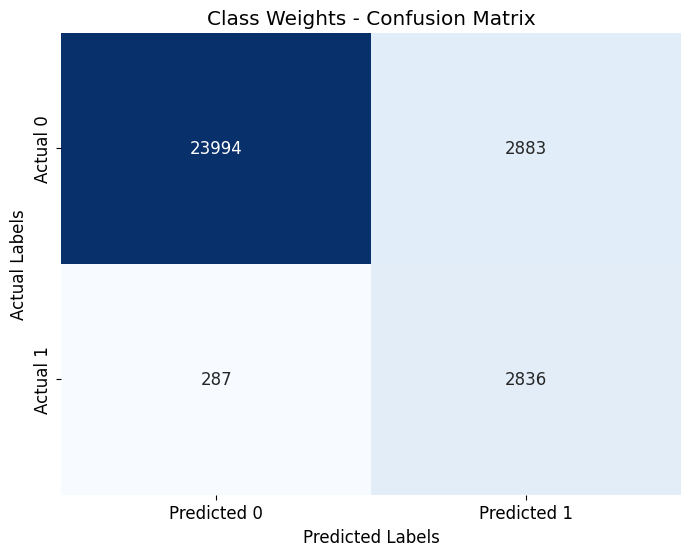

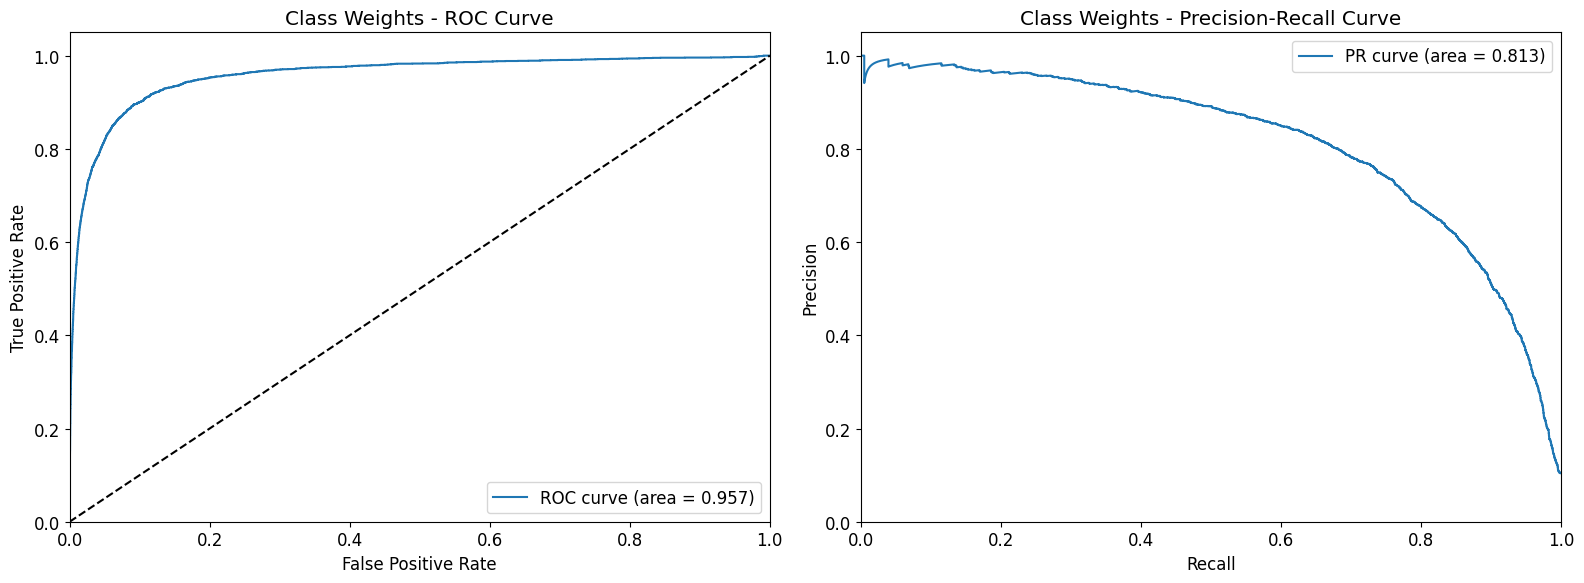

In [9]:
# Addestrare un modello con pesi di classe
weighted_model = LogisticRegression(class_weight='balanced', random_state=42)
weighted_results = evaluate_model(weighted_model, X_train, X_test, y_train, y_test, "Class Weights")

### 4.2 Regolazione della soglia

Invece di usare la soglia predefinita di 0,5 per la classificazione, possiamo regolarla per migliorare le prestazioni sulla classe di minoranza.

Optimal threshold: 0.1306

Threshold Adjustment - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95     26877
           1       0.54      0.87      0.67      3123

    accuracy                           0.91     30000
   macro avg       0.76      0.89      0.81     30000
weighted avg       0.94      0.91      0.92     30000



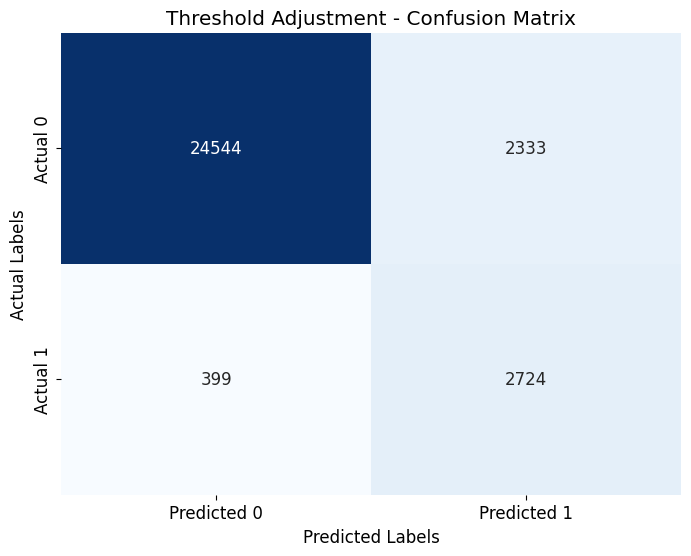

In [10]:
# Addestrare un modello regolare
threshold_model = LogisticRegression(random_state=42)
threshold_model.fit(X_train, y_train)

# Ottieni le probabilità
y_prob = threshold_model.predict_proba(X_test)[:, 1]

# Trova la soglia ottimale utilizzando la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")

# Fare previsioni con la soglia ottimale
y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)

# Valutare con soglia aggiustata
print("\nThreshold Adjustment - Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Matrice di confusione con soglia regolata
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'])
plt.title('Threshold Adjustment - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

#### SPIEGAZIONE DEL CODICE SOPRA


### 1. **Allena un modello di regressione logistica**:
```python
threshold_model = LogisticRegression(random_state=42)
threshold_model.fit(X_train, y_train)
```
- Qui stai allenando un modello di **Regressione Logistica** sui dati di addestramento `X_train` (caratteristiche) e `y_train` (etichette).
- `random_state=42` serve per fissare il seme del generatore di numeri casuali, così da ottenere gli stessi risultati ogni volta che esegui il codice.

### 2. **Ottieni le probabilità**:
```python
y_prob = threshold_model.predict_proba(X_test)[:, 1]
```
- Il metodo `.predict_proba(X_test)` restituisce le probabilità previste per ogni classe (0 e 1) sui dati di test `X_test`.
- Qui stai selezionando le probabilità relative alla classe positiva (classe 1) usando `[:, 1]`. Questo ti dà la probabilità che ogni esempio di test appartenga alla classe 1.

### 3. **Trova la soglia ottimale usando la curva ROC**:
```python
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.4f}")
```
- **ROC curve (Receiver Operating Characteristic)** è una curva che ti aiuta a capire come il modello si comporta a vari valori di soglia (threshold) per la decisione tra la classe 0 e la classe 1.
  - `fpr` è il **tasso di falsi positivi** (false positive rate).
  - `tpr` è il **tasso di veri positivi** (true positive rate, ovvero la sensibilità).
  - `thresholds` sono i vari valori della soglia per cui sono calcolati `fpr` e `tpr`.
  
- La **soglia ottimale** viene determinata come quella per cui la differenza tra il tasso di veri positivi (`tpr`) e il tasso di falsi positivi (`fpr`) è massima. Questo punto rappresenta una buona bilanciata tra sensibilità e specificità.
- `optimal_threshold` è la soglia ottimale che hai trovato.

### 4. **Previsioni con la soglia ottimale**:
```python
y_pred_adjusted = (y_prob >= optimal_threshold).astype(int)
```
- Qui stai facendo le previsioni con la soglia ottimale che hai trovato.
- Se la probabilità prevista per la classe 1 è maggiore o uguale alla soglia ottimale, la previsione sarà 1 (classe positiva); altrimenti sarà 0 (classe negativa).
- `.astype(int)` serve a convertire il risultato in un array di interi (0 o 1).

### 5. **Valutazione con la soglia ottimizzata**:
```python
print("\nThreshold Adjustment - Classification Report:")
print(classification_report(y_test, y_pred_adjusted))
```
- Con il `classification_report`, puoi vedere varie metriche di valutazione per il modello, come:
  - **Precisione**: quanto spesso le previsioni di classe positiva (1) sono corrette.
  - **Richiamo (Recall)**: quanto spesso il modello trova la classe positiva quando è effettivamente presente.
  - **F1-score**: una media armonica di precisione e richiamo.
  - **Accuratezza**: la percentuale di previsioni corrette.
  
### 6. **Matrice di Confusione con soglia ottimizzata**:
```python
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'])
plt.title('Threshold Adjustment - Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()
```
- **Matrice di Confusione**: una matrice che mostra il numero di predizioni corrette e sbagliate. 
  - La matrice ha quattro celle: veri positivi (TP), falsi positivi (FP), veri negativi (TN) e falsi negativi (FN).
- Viene utilizzata la libreria **seaborn** per visualizzare la matrice in un formato a colori (mappa di calore). L'annotazione nella matrice (`annot=True`) mostrerà i numeri effettivi nelle celle.
- In questo caso, la matrice di confusione viene tracciata per valutare come il modello ha predetto le classi rispetto ai valori reali (`y_test`) con la soglia ottimizzata.

### Riassunto
Il codice serve a:
1. Allenare un modello di regressione logistica.
2. Trovare la soglia ottimale usando la curva ROC.
3. Fare previsioni con la soglia ottimale.
4. Valutare il modello utilizzando report di classificazione e una matrice di confusione per capire come il modello sta performando.



## 5. Confronto dei risultati

Confrontiamo le prestazioni di tutti gli approcci che abbiamo provato.

Model Performance Comparison:
                        ROC-AUC    PR-AUC
Baseline (Imbalanced)  0.954352  0.827047
Undersampling          0.957427  0.813415
Class Weights          0.957453  0.813092
Oversampling           0.957515  0.812960
SMOTE                  0.957498  0.811496


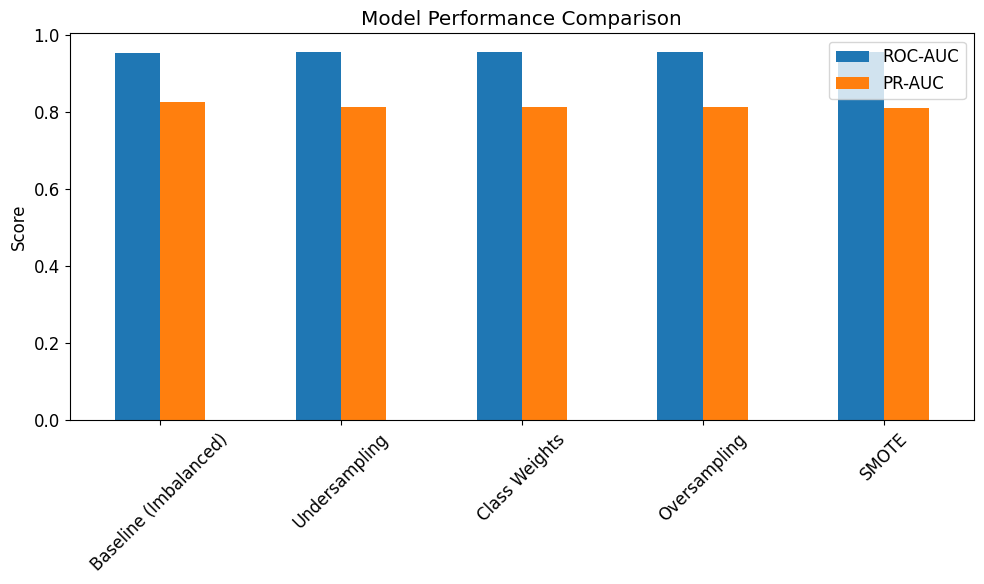

In [11]:
# Collect results
results = {
    'Baseline (Imbalanced)': baseline_results,
    'Undersampling': undersample_results,
    'Oversampling': oversample_results,
    'SMOTE': smote_results,
    'Class Weights': weighted_results,
}

# Compare ROC-AUC and PR-AUC
metrics = {
    'ROC-AUC': [result['roc_auc'] for result in results.values()],
    'PR-AUC': [result['pr_auc'] for result in results.values()]
}

comparison_df = pd.DataFrame(metrics, index=results.keys())
comparison_df = comparison_df.sort_values('PR-AUC', ascending=False)

print("Model Performance Comparison:")
print(comparison_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### SPIEGAZIONE CODICE SOPRA

### 1. **Collezionare i risultati**:
```python
results = {
    'Baseline (Imbalanced)': baseline_results,
    'Undersampling': undersample_results,
    'Oversampling': oversample_results,
    'SMOTE': smote_results,
    'Class Weights': weighted_results,
}
```
- Qui stai creando un dizionario `results` che raccoglie i risultati di diversi metodi per trattare il problema di **classe sbilanciata**. Ogni chiave rappresenta una tecnica specifica, e ogni valore è un oggetto che contiene i risultati ottenuti da quella tecnica. 
  - **Baseline (Imbalanced)**: I risultati del modello senza alcuna tecnica di bilanciamento.
  - **Undersampling**: Tecnica in cui riduci il numero delle classi maggioritarie per bilanciare il dataset.
  - **Oversampling**: Tecnica in cui aumenti il numero delle classi minoritarie per bilanciare il dataset.
  - **SMOTE**: Tecnica di oversampling sintetico che genera nuovi esempi della classe minoritaria.
  - **Class Weights**: Utilizzo dei pesi per penalizzare maggiormente gli errori sulla classe minoritaria, invece di cambiare la distribuzione dei dati.

### 2. **Creare un dizionario con le metriche ROC-AUC e PR-AUC**:
```python
metrics = {
    'ROC-AUC': [result['roc_auc'] for result in results.values()],
    'PR-AUC': [result['pr_auc'] for result in results.values()]
}
```
- Qui stai creando un altro dizionario `metrics`, che raccoglie due metriche di valutazione per ciascun metodo di bilanciamento: **ROC-AUC** e **PR-AUC**.
  - **ROC-AUC**: è una misura della qualità del modello in relazione alla curva ROC (Receiver Operating Characteristic). Il valore dell'AUC (Area Under the Curve) va da 0 a 1, con valori più alti che indicano un modello migliore.
  - **PR-AUC**: è una misura simile ma calcolata sulla **Precision-Recall curve**. È particolarmente utile quando hai un dataset sbilanciato, poiché si concentra sul comportamento del modello rispetto alla classe positiva.

- Per ottenere questi valori, stai estraendo `'roc_auc'` e `'pr_auc'` da ogni risultato nel dizionario `results`.

### 3. **Creare un DataFrame per la comparazione**:
```python
comparison_df = pd.DataFrame(metrics, index=results.keys())
```
- In questo passaggio, stai creando un **DataFrame** di pandas chiamato `comparison_df` usando il dizionario `metrics`. 
- Le chiavi di `results` (ad esempio, 'Baseline (Imbalanced)', 'Undersampling', etc.) diventano l'indice delle righe, mentre le metriche `ROC-AUC` e `PR-AUC` diventano le colonne.

### 4. **Ordinare il DataFrame per PR-AUC**:
```python
comparison_df = comparison_df.sort_values('PR-AUC', ascending=False)
```
- Ora stai ordinando il DataFrame `comparison_df` in base alla metrica **PR-AUC**, in ordine decrescente (dal valore più alto al più basso). Questo ti permette di vedere quale metodo di bilanciamento ha avuto le migliori performance secondo la metrica PR-AUC.

### 5. **Stampare il confronto delle performance**:
```python
print("Model Performance Comparison:")
print(comparison_df)
```
- Qui semplicemente stampi il DataFrame `comparison_df` che mostra una comparazione delle performance tra i vari metodi di bilanciamento, in base ai punteggi ROC-AUC e PR-AUC.

### 6. **Visualizzare la comparazione con un grafico a barre**:
```python
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```
- Qui stai creando un grafico a barre per visualizzare le performance dei vari metodi di bilanciamento. 
  - `plt.figure(figsize=(10, 6))`: imposta la dimensione della figura del grafico.
  - `comparison_df.plot(kind='bar', ax=plt.gca())`: crea un grafico a barre usando il DataFrame `comparison_df`. Ogni barra rappresenta il punteggio (ROC-AUC o PR-AUC) di un metodo.
  - `plt.title('Model Performance Comparison')`: aggiunge un titolo al grafico.
  - `plt.ylabel('Score')`: etichetta sull'asse delle ordinate (punteggi delle metriche).
  - `plt.xticks(rotation=45)`: ruota le etichette sull'asse delle ascisse (metodi) di 45 gradi, per renderle più leggibili.
  - `plt.tight_layout()`: regola automaticamente il layout per evitare sovrapposizioni di elementi nel grafico.
  - `plt.show()`: visualizza il grafico.

### Riassunto:
- Il codice raccoglie e confronta le performance di vari modelli applicati a tecniche di bilanciamento dei dati (come undersampling, oversampling, SMOTE, etc.), utilizzando le metriche **ROC-AUC** e **PR-AUC**.
- Il risultato finale è una tabella che mostra le performance di ciascun metodo e un grafico a barre che rende visibile la comparazione.

Se hai altre domande o bisogno di chiarimenti, fammi sapere!

## Conclusione

Esistono diversi approcci per gestire set di dati sbilanciati (ne abbiamo analizzati solo alcuni):

1. **Tecniche di ricampionamento**:
- Sottocampionamento (casuale, NearMiss, collegamenti Tomek)
- Sovracampionamento (casuale, SMOTE, ADASYN)

2. **Approcci a livello di algoritmo**:
- Ponderazione di classe
- Adeguamento della soglia

3. **Metodi di ensemble**:
- Foresta casuale bilanciata

### Punti chiave

- L'approccio migliore dipende dal tuo set di dati specifico e dai tuoi requisiti
- Per set di dati di piccole dimensioni, il sovracampionamento è spesso migliore del sottocampionamento per evitare la perdita di informazioni
- SMOTE generalmente funziona meglio del semplice sovracampionamento casuale
- La ponderazione di classe è un approccio semplice ma efficace
- Utilizzare sempre metriche di valutazione appropriate (PR-AUC, F1-SCORE, ecc.) per set di dati sbilanciati
- Considerare il compromesso tra precisione e richiamo in base alla tua applicazione needs

### Best Practices

1. Suddividere sempre i dati prima di applicare tecniche di ricampionamento per evitare perdite di dati
2. Utilizzare il campionamento stratificato per mantenere la distribuzione delle classi nelle suddivisioni di training/test
3. Provare più approcci e confrontarne le prestazioni
4. Scegliere metriche di valutazione in linea con gli obiettivi aziendali
5. Considerare i costi dei falsi positivi rispetto ai falsi negativi nella propria applicazione specifica

# 6. Rilevamento delle anomalie

## 6.1. Cosa sono le anomalie?

Le anomalie (chiamate anche valori anomali) sono punti dati che si discostano in modo significativo dalla maggior parte dei dati. Possono essere causate da:
- Errori di misurazione
- Variazione naturale
- Attività fraudolenta
- Errori di sistema
- Nuovi modelli o eventi rari

### Perché il rilevamento delle anomalie è importante?

- **Rilevamento delle frodi**: identificazione di transazioni sospette
- **Sicurezza di rete**: rilevamento di intrusioni o modelli di accesso insoliti
- **Produzione**: controllo di qualità e rilevamento di guasti
- **Medicina**: identificazione di modelli di pazienti insoliti
- **Pulizia dei dati**: rimozione o analisi di valori errati prima dell'analisi

In [12]:
from sklearn.datasets import make_blobs

## Creazione di dati sintetici

Creiamo un set di dati con punti normali e alcune anomalie evidenti.

In [13]:
# Generare dati sintetici con cluster
X_normal, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=42, cluster_std=2)

# Crea alcune anomalie evidenti
X_anomalies = np.random.uniform(low=-15, high=15, size=(15, 2))

# Combina dati normali e anomali
X = np.vstack([X_normal, X_anomalies])
labels = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomalies))])

# Converti in DataFrame per una manipolazione più semplice
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['is_anomaly'] = labels

# Visualizza le prime righe
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (315, 3)


,feature1,feature2,is_anomaly
0,5.316872,1.142594,0.0
1,5.917064,-1.349870,0.0
2,-2.536192,6.898864,0.0
3,5.734074,1.568784,0.0
4,5.219429,6.123971,0.0


#### SPIEGAZIONE DEL CODICE 
Vediamo passo dopo passo cosa fa questo codice.

### 1. **Generazione dei dati sintetici con cluster**:
```python
X_normal, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=42, cluster_std=2)
```
- **`make_blobs()`** è una funzione di **scikit-learn** utilizzata per generare dati sintetici in forma di **cluster**.
  - **`n_samples=300`**: Vengono generati 300 campioni di dati.
  - **`centers=2`**: I dati sono divisi in 2 cluster distinti.
  - **`n_features=2`**: Ogni campione ha 2 caratteristiche (feature), quindi i dati generati sono in un piano bidimensionale.
  - **`random_state=42`**: Fissa il seme del generatore di numeri casuali per garantire che i risultati siano riproducibili.
  - **`cluster_std=2`**: La deviazione standard dei cluster è 2, il che significa che i punti all'interno di ciascun cluster sono distribuiti con una certa dispersione.

- La funzione **`make_blobs()`** restituisce due variabili:
  - **`X_normal`**: Un array di shape (300, 2) che contiene le coordinate dei 300 campioni generati nei 2 cluster.
  - **`y`**: Un array di etichette (0 o 1) che indica a quale cluster appartiene ciascun campione. Queste etichette sono inutilizzate nel codice successivo, ma normalmente rappresentano la classe di appartenenza (cluster 0 o cluster 1).

### 2. **Creazione delle anomalie evidenti**:
```python
X_anomalies = np.random.uniform(low=-15, high=15, size=(15, 2))
```
- Qui vengono generate **15 anomalie** (dati fuori dai cluster principali) con **coordinate casuali**.
  - **`np.random.uniform(low=-15, high=15, size=(15, 2))`** crea 15 punti con **valori casuali** compresi tra -15 e 15 (sia per la prima che per la seconda caratteristica).
  - Questi punti sono distribuiti uniformemente in un intervallo molto ampio rispetto ai cluster, creando **anomalie** che si trovano lontano dai cluster originari.

### 3. **Combinazione dei dati normali e delle anomalie**:
```python
X = np.vstack([X_normal, X_anomalies])
labels = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomalies))])
```
- **`np.vstack([X_normal, X_anomalies])`**: Combina i dati normali (300 campioni) con le anomalie (15 campioni) lungo la **dimensione verticale** (aggiungendo le anomalie in fondo ai dati normali).
  - **`X`** ora è un array di dimensione (315, 2), che contiene sia i punti normali che le anomalie.
  
- **`np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomalies))])`**: Crea un array di etichette, dove:
  - Le etichette per i dati normali sono **0** (cluster 0).
  - Le etichette per le anomalie sono **1** (indicando che questi punti sono anomali).
  - Alla fine, ottieni un array di etichette di dimensione (315,) che contiene 0 per i dati normali e 1 per le anomalie.

### 4. **Conversione in un DataFrame per una manipolazione più semplice**:
```python
df = pd.DataFrame(X, columns=['feature1', 'feature2'])
df['is_anomaly'] = labels
```
- Qui stai creando un **DataFrame di pandas** con i dati di input `X` e aggiungendo una colonna per le etichette (`is_anomaly`).
  - **`X`** è l'array che contiene i dati delle caratteristiche (due colonne: `feature1` e `feature2`).
  - La colonna **`is_anomaly`** viene popolata con le etichette, dove 0 indica un punto normale e 1 un'anomalia.

### 5. **Visualizza le prime righe del DataFrame**:
```python
print(f"Dataset shape: {df.shape}")
df.head()
```
- **`df.shape`** stampa la **dimensione** del DataFrame (315 righe e 3 colonne: `feature1`, `feature2`, e `is_anomaly`).
- **`df.head()`** mostra le prime 5 righe del DataFrame, consentendo di visualizzare una parte dei dati generati.

### Riassunto:
- Il codice crea un dataset sintetico che simula un problema di **rilevamento delle anomalie**.
- Prima genera due cluster di dati normali usando **`make_blobs`**, poi crea alcune **anomalie** (dati fuori dai cluster), e infine combina i due set di dati in un unico array.
- Ogni punto viene etichettato come normale (0) o anomalo (1).
- I dati vengono poi convertiti in un **DataFrame** per una manipolazione più semplice e visualizzati le prime righe.

Questo codice potrebbe essere utile per allenare e testare modelli di **rilevamento delle anomalie** su un dataset sintetico.

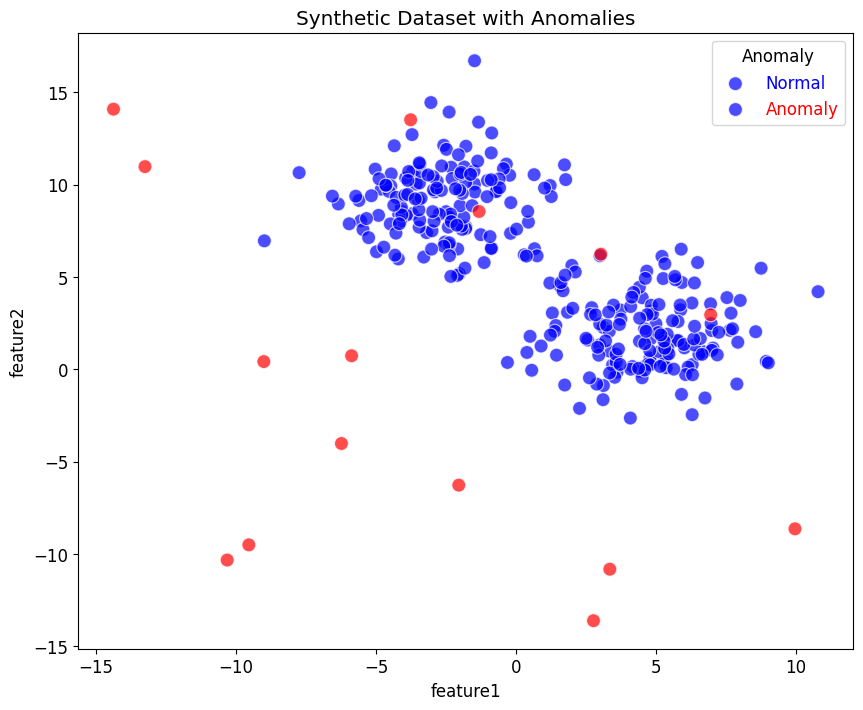

In [14]:
# Visualize the dataset
plt.figure(figsize=(10, 8))
sns.scatterplot(x='feature1', y='feature2', hue='is_anomaly', 
                palette={0: 'blue', 1: 'red'}, 
                data=df, s=100, alpha=0.7)
plt.title('Synthetic Dataset with Anomalies')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'], labelcolor=['blue','red'])

plt.show()

#### SPIEGAZIONE CODICE SOPRA

Questo codice serve a **visualizzare il dataset** sintetico che hai creato, mostrando i dati **normali** e le **anomalie** in un grafico a dispersione (scatter plot).

Ecco cosa fa ogni parte del codice:

### 1. **Imposta la figura del grafico**:
```python
plt.figure(figsize=(10, 8))
```
- **`plt.figure(figsize=(10, 8))`** imposta le dimensioni della figura del grafico, rendendola abbastanza grande per essere facilmente leggibile (larghezza 10, altezza 8).

### 2. **Crea un grafico a dispersione (scatter plot)**:
```python
sns.scatterplot(x='feature1', y='feature2', hue='is_anomaly', 
                palette={0: 'blue', 1: 'red'}, 
                data=df, s=100, alpha=0.7)
```
- **`sns.scatterplot()`** è una funzione di **Seaborn** per creare un grafico a dispersione.
  - **`x='feature1'`**: L'asse x del grafico è costituito dai valori della colonna `feature1`.
  - **`y='feature2'`**: L'asse y del grafico è costituito dai valori della colonna `feature2`.
  - **`hue='is_anomaly'`**: Colora i punti in base alla colonna `is_anomaly` che contiene 0 per i dati normali e 1 per le anomalie. Questo permette di differenziare visivamente i punti normali (0) da quelli anomali (1).
  - **`palette={0: 'blue', 1: 'red'}`**: Usa un colore **blu** per i dati normali (`is_anomaly == 0`) e un colore **rosso** per le anomalie (`is_anomaly == 1`).
  - **`data=df`**: Indica che i dati provengono dal DataFrame `df`.
  - **`s=100`**: Imposta la dimensione dei punti nel grafico, in questo caso 100, per renderli più grandi.
  - **`alpha=0.7`**: Imposta la trasparenza dei punti al 70% (valore 1 è opaco, valore 0 è completamente trasparente), il che aiuta a visualizzare i punti sovrapposti.

### 3. **Aggiungi il titolo al grafico**:
```python
plt.title('Synthetic Dataset with Anomalies')
```
- **`plt.title()`** aggiunge il titolo al grafico, in questo caso **"Synthetic Dataset with Anomalies"**.

### 4. **Aggiungi la legenda**:
```python
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'], labelcolor=['blue','red'])
```
- **`plt.legend()`** aggiunge una legenda al grafico.
  - **`title='Anomaly'`** imposta il titolo della legenda come "Anomaly".
  - **`labels=['Normal', 'Anomaly']`** definisce le etichette che appariranno nella legenda, indicando che i dati con valore 0 (blu) sono **"Normal"** e quelli con valore 1 (rosso) sono **"Anomaly"**.
  - **`labelcolor=['blue','red']`** imposta i colori della legenda, abbinando **blu** ai dati normali e **rosso** alle anomalie.

### 5. **Visualizza il grafico**:
```python
plt.show()
```
- **`plt.show()`** visualizza il grafico a dispersione creato.

### Riassunto:
Questo codice crea un **grafico a dispersione** che mostra i dati generati, dove i **punti blu** rappresentano i dati **normali** (cluster) e i **punti rossi** rappresentano le **anomalie**. Viene aggiunta anche una **legenda** per spiegare il significato dei colori, e viene impostato un titolo per il grafico.

### Risultato atteso:
- Nel grafico, vedrai i dati normali distribuiti in due cluster (probabilmente vicini tra loro) e le anomalie (punti rossi) lontano da questi cluster, a causa della loro generazione casuale in un intervallo ampio.


## 6.2. Approcci di rilevamento delle anomalie

Esistono diversi approcci al rilevamento delle anomalie:

1. **Supervisionato**: utilizza dati etichettati con esempi sia normali che anomali
2. **Semi-supervisionato**: addestrato solo su dati normali, quindi identifica le deviazioni
3. **Non supervisionato**: non sono richieste etichette, identifica i pattern che si discostano dalla maggioranza

In questo notebook, ci concentreremo sui metodi non supervisionati e semi-supervisionati, poiché sono più comuni negli scenari del mondo reale in cui le anomalie sono rare e spesso non etichettate.


Approfondiamo i **vari approcci al rilevamento delle anomalie**: supervisionato, semi-supervisionato e non supervisionato. Ognuno di questi ha applicazioni e tecniche diverse, e la scelta dipende dal tipo di dati disponibili e dal contesto in cui vengono utilizzati.

### 1. **Rilevamento delle anomalie supervisionato**:
#### Cos'è:
Il **rilevamento delle anomalie supervisionato** si basa su dati etichettati. Ciò significa che hai sia esempi di **dati normali** che **dati anomali** e usi queste etichette per allenare il modello.

#### Come funziona:
- **Addestramento del modello**: Viene addestrato un modello di machine learning utilizzando un dataset che contiene sia esempi **normali** (classificati come "0") che **anomalie** (classificati come "1").
- **Predizione**: Una volta addestrato, il modello è in grado di classificare nuovi dati come normali o anomali in base alle caratteristiche che ha imparato.

#### Vantaggi:
- Le etichette esplicite permettono di addestrare un modello che può avere una buona precisione nella rilevazione delle anomalie.
- Può essere utilizzato per applicazioni dove le anomalie sono relativamente comuni e facilmente etichettabili.

#### Svantaggi:
- **Richiesta di dati etichettati**: È necessario avere un set di dati con etichette di anomalie, il che potrebbe non essere possibile o troppo costoso in scenari reali.
- La qualità del modello dipende dalla qualità e completezza delle etichette fornite, quindi la raccolta di etichette di qualità può essere difficile.

#### Esempi di algoritmi supervisionati:
- **Logistic Regression**: Quando il problema è binario, la regressione logistica può essere utilizzata per prevedere la probabilità di appartenenza a una classe anomala.
- **Support Vector Machines (SVM)**: Un SVM può essere utilizzato con un kernel non lineare per separare le anomalie dai dati normali.
- **Decision Trees e Random Forests**: Questi algoritmi possono essere addestrati a riconoscere pattern nei dati etichettati e classificare nuovi campioni come normali o anomali.

### 2. **Rilevamento delle anomalie semi-supervisionato**:
#### Cos'è:
Nel **rilevamento delle anomalie semi-supervisionato**, il modello è addestrato **solo sui dati normali** (cioè, il modello non ha etichette di anomalie), e cerca quindi di identificare ciò che si discosta da questa norma come un'anomalia.

#### Come funziona:
- **Addestramento del modello**: Il modello viene addestrato solo sui dati **normali**, imparando le caratteristiche della distribuzione dei dati normali.
- **Predizione**: Quando si presentano nuovi dati, il modello esamina quanto si discostano dalle distribuzioni di probabilità apprese dai dati normali. Se un punto ha caratteristiche significativamente diverse, viene etichettato come **anomalìa**.

#### Vantaggi:
- Non è necessario avere etichette di anomalie. Si può utilizzare un set di dati che contiene solo dati normali, che è più comune nelle applicazioni reali.
- Questo approccio è utile quando le anomalie sono rare e difficili da etichettare, ma puoi comunque avere accesso a una buona quantità di dati normali.

#### Svantaggi:
- Il modello potrebbe non rilevare tutte le anomalie, soprattutto se alcune anomalie sono molto simili ai dati normali.
- Non ha informazioni esplicite sulle anomalie, quindi potrebbe essere meno preciso rispetto ai metodi supervisionati.

#### Esempi di algoritmi semi-supervisionati:
- **One-Class SVM**: Una variante di SVM che viene addestrata solo sui dati normali. Si cerca di trovare un iperpiano che separi i dati normali dallo spazio vuoto, e qualsiasi punto fuori da questa regione viene considerato un'anomalia.
- **Isolation Forest**: Un algoritmo che costruisce alberi binari per isolare i punti anomali dai dati normali. Viene addestrato solo sui dati normali e identifica le anomalie come punti difficili da isolare.
- **Autoencoder**: Una rete neurale addestrata sui dati normali per "ricostruire" il dato in ingresso. Se la ricostruzione è errata (cioè l'errore di ricostruzione è grande), il dato potrebbe essere un'anomalia. Questo approccio è ampiamente utilizzato per dati non strutturati come immagini.

### 3. **Rilevamento delle anomalie non supervisionato**:
#### Cos'è:
Il **rilevamento delle anomalie non supervisionato** non richiede alcun tipo di etichetta. L'algoritmo cerca di identificare le anomalie scoprendo **pattern che si discostano dalla maggioranza**.

#### Come funziona:
- **Addestramento del modello**: L'algoritmo analizza il dataset senza etichette e cerca di identificare modelli, cluster o altre strutture nei dati. Qualsiasi dato che si discosta in modo significativo da questi modelli viene etichettato come anomalia.
- **Predizione**: I punti che appaiono **lontani** dai cluster principali o che hanno una bassa densità rispetto al resto dei dati vengono considerati anomalie.

#### Vantaggi:
- **Nessuna necessità di etichette**: Non è necessario alcun dato etichettato, il che è molto utile nei casi reali, dove le anomalie sono rare e difficilmente etichettabili.
- Utilizza tecniche di **analisi esplorativa** per trovare schemi nei dati.

#### Svantaggi:
- L'algoritmo potrebbe non rilevare anomalie in scenari complessi o con dati molto eterogenei.
- Potrebbe essere meno preciso rispetto agli approcci supervisionati, poiché non ha informazioni esplicite sulle anomalie.

#### Esempi di algoritmi non supervisionati:
- **K-means Clustering**: Utilizza la **clustralizzazione** dei dati per identificare gruppi. I punti che non appartengono a nessun cluster o che appartengono a cluster di bassa densità sono considerati anomalie.
- **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: Un algoritmo di clustering basato sulla densità che può identificare i punti che non appartengono a nessun cluster (cioè le anomalie).
- **Local Outlier Factor (LOF)**: Misura la densità locale dei punti e identifica come anomalie i punti che hanno una densità significativamente inferiore rispetto ai loro vicini.

### Riassunto:
- **Supervisionato**: Usa dati etichettati e addestra il modello a riconoscere anomalie e dati normali. Ha alta precisione, ma richiede dati etichettati.
- **Semi-supervisionato**: Addestra il modello solo su dati normali e cerca ciò che si discosta come anomalia. È utile quando le anomalie sono rare e difficili da etichettare.
- **Non supervisionato**: Non usa etichette e trova anomalie cercando schemi che si discostano dai dati normali. È utile quando non ci sono etichette disponibili e le anomalie sono difficili da definire.

Nel contesto del **rilevamento delle anomalie**, gli approcci **semi-supervisionati e non supervisionati** sono molto utili in scenari reali, poiché spesso le anomalie sono rare e non etichettate.

## Metodi statistici

### Metodo Z-Score
Uno degli approcci più semplici è l'utilizzo di z-score (deviazioni standard dalla media). I punti con z-score assoluti maggiori di una soglia (tipicamente 3) sono considerati anomalie.

 Approfondiamo il **metodo Z-score**, un approccio statistico semplice ma efficace per rilevare le anomalie nei dati.

### **Cos'è lo Z-score?**

Lo **Z-score** (o **score standardizzato**) è una misura che indica quanto un dato si discosta dalla **media** di un insieme di dati in termini di **deviazioni standard**. In altre parole, lo Z-score ci dice quanto un dato è lontano dalla media del dataset rispetto alla variabilità dei dati.

### Interpretazione dello Z-score:
- **Z = 0**: Il dato è esattamente uguale alla **media**.
- **Z > 0**: Il dato è **maggiore** della media.
- **Z < 0**: Il dato è **minore** della media.
- **|Z| > 3**: Un valore di Z superiore a 3 (o inferiore a -3) indica che il dato è **molto distante** dalla media, cioè una **potenziale anomalia**.

### **Come viene utilizzato lo Z-score per il rilevamento delle anomalie?**

Nel contesto del **rilevamento delle anomalie**, l'idea principale è che **i dati anomali** sono **molto distanti** dalla distribuzione dei dati normali, quindi avranno un Z-score **alto** (positivo o negativo).

#### Passaggi principali:
1. **Calcolare la media (\( \mu \)) e la deviazione standard (\( \sigma \))** dei dati.
2. **Calcolare lo Z-score** per ogni punto del dataset utilizzando la formula.
3. **Identificare le anomalie**: Punti che hanno un **Z-score assoluto maggiore di una soglia predefinita** (tipicamente 3) sono considerati anomalie.

Ad esempio:
- Se lo Z-score di un dato è maggiore di **3** o minore di **-3**, significa che il dato è a più di 3 deviazioni standard dalla media e viene considerato un'anomalia.
  
### **Soglia del Z-score**
Una soglia comune per identificare le anomalie è un **Z-score assoluto maggiore di 3**. Questo perché, nella distribuzione normale (Gaussiana), circa il **99.7%** dei dati si trova entro 3 deviazioni standard dalla media. Quindi, qualsiasi punto che si trovi a più di 3 deviazioni standard dalla media è un caso raro e potrebbe essere un'anomalia.

### **Vantaggi del metodo Z-score**:
- **Semplicità**: È facile da comprendere e implementare.
- **Efficace per distribuzioni normali**: Funziona particolarmente bene quando i dati seguono una distribuzione normale (gaussiana), in cui la maggior parte dei punti è concentrata attorno alla media.
- **Rapido**: Il calcolo dello Z-score è veloce, soprattutto per dataset di piccole e medie dimensioni.

### **Svantaggi**:
- **Assunzione di distribuzione normale**: Il metodo assume che i dati siano distribuiti in modo normale (gaussiano). Se i dati non seguono una distribuzione normale, lo Z-score potrebbe non essere efficace nel rilevare le anomalie.
- **Sensibile a valori estremi**: Se ci sono già **outlier** nel dataset (valori estremi), possono influenzare notevolmente la media e la deviazione standard, distorcendo i calcoli degli Z-score.
- **Non adatto per dati non strutturati**: Funziona meglio per dati numerici e ben distribuiti, ma può essere meno utile per dati complessi o non strutturati come immagini o testi.

### **Modifiche al metodo Z-score**:
- In alcune varianti, puoi **normalizzare i dati** (ad esempio, con la **scaling** o la **trasformazione logaritmica**) per renderli più adatti al calcolo dello Z-score, specialmente se i dati non sono distribuiti normalmente.
- Puoi anche **scegliere soglie diverse** (ad esempio 2 o 4) a seconda del contesto e delle specifiche esigenze del tuo modello.

### **Conclusioni**:
Il **metodo Z-score** è un approccio statistico semplice ma potente per il rilevamento delle anomalie, particolarmente utile quando i dati seguono una distribuzione normale. Identifica facilmente i punti che si discostano significativamente dalla media, ma richiede che i dati abbiano una distribuzione relativamente regolare per essere efficace.

Se i tuoi dati non seguono una distribuzione normale, potresti dover considerare altre tecniche di rilevamento delle anomalie, come metodi non parametrici o basati su modelli complessi.

In [15]:
def z_score_detector(data, threshold=1.5):
    """Detect anomalies using Z-score method"""
    # Calculate z-scores for each feature
    z_scores = pd.DataFrame()
    for column in data.select_dtypes(include=[np.number]).columns:
        z_scores[column] = (data[column] - data[column].mean()) / data[column].std()
    
    # Find rows where any feature has |z-score| > threshold
    outliers = (z_scores.abs() > threshold).any(axis=1)
    return outliers

# Apply to our dataset (excluding the 'is_anomaly' column)
detected_outliers = z_score_detector(df[['feature1', 'feature2']])

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(df['is_anomaly'], detected_outliers)
precision = precision_score(df['is_anomaly'], detected_outliers)
recall = recall_score(df['is_anomaly'], detected_outliers)
f1 = f1_score(df['is_anomaly'], detected_outliers)

print(f"Z-Score Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Z-Score Method Performance:
Accuracy: 0.9016
Precision: 0.3000
Recall: 0.8000
F1 Score: 0.4364


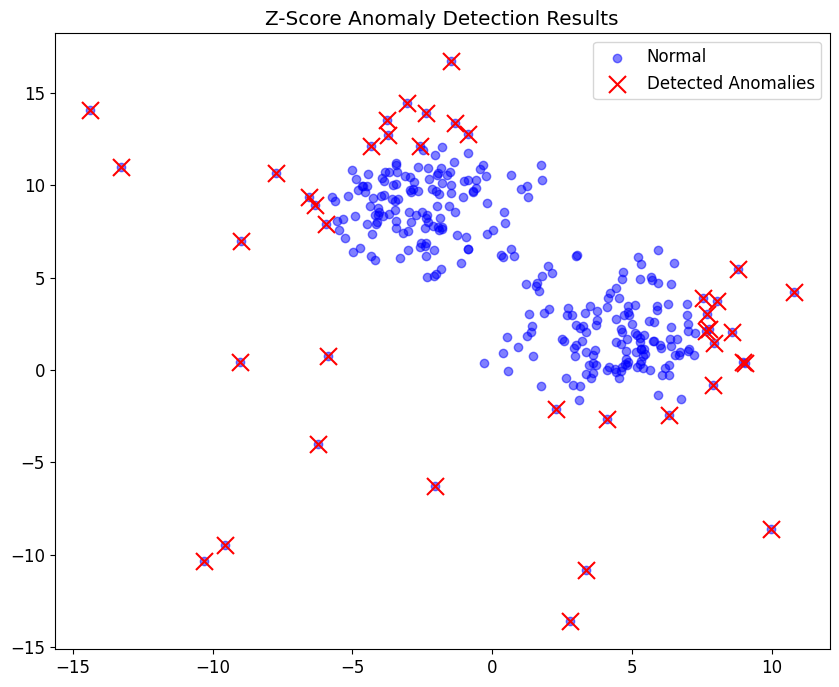

In [16]:
# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[detected_outliers, 'feature1'], df.loc[detected_outliers, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Z-Score Anomaly Detection Results')
plt.legend()
plt.show()

#### DESCRIZIONE DEL CODICE

### 1. **Funzione `z_score_detector`**
La funzione `z_score_detector` viene utilizzata per rilevare le anomalie nei dati utilizzando il metodo dello Z-score.

```python
def z_score_detector(data, threshold=1.5):
    """Detect anomalies using Z-score method"""
    # Calcola gli Z-score per ogni feature
    z_scores = pd.DataFrame()
    for column in data.select_dtypes(include=[np.number]).columns:
        z_scores[column] = (data[column] - data[column].mean()) / data[column].std()
    
    # Trova le righe in cui una qualsiasi feature ha |z-score| > threshold
    outliers = (z_scores.abs() > threshold).any(axis=1)
    return outliers
```

- **Input**: La funzione prende in input i dati (`data`) e una soglia (`threshold`), che di default è 1.5. La soglia determina quanto un dato deve deviare dalla media per essere considerato un'anomalia.
  
- **Calcolo dello Z-score**:
  - Lo Z-score viene calcolato per ogni **colonna numerica** (features) nel dataset. Per ogni feature, il calcolo dello Z-score è:
    \[
    Z = \frac{X - \mu}{\sigma}
    \]
    Dove:
    - \( X \) è il valore del dato,
    - \( \mu \) è la media della feature,
    - \( \sigma \) è la deviazione standard della feature.
  - La funzione `data[column].mean()` calcola la media e `data[column].std()` calcola la deviazione standard della colonna.

- **Determinazione delle anomalie**:
  - Una volta calcolati gli Z-score, vengono confrontati con la **soglia**.
  - Se **|Z-score|** è maggiore della soglia (1.5), il dato è considerato un'anomalia.
  - La funzione `z_scores.abs() > threshold` restituisce un DataFrame booleano dove ogni valore indica se lo Z-score è maggiore della soglia. La funzione `any(axis=1)` restituisce `True` se **almeno una colonna** in una riga ha un Z-score maggiore della soglia (cioè, se c'è almeno una feature anomala nella riga).

- **Output**: La funzione restituisce una **serie booleana** (`outliers`), dove `True` indica che la riga è un'anomalia.

### 2. **Applicazione del metodo sui dati**
```python
detected_outliers = z_score_detector(df[['feature1', 'feature2']])
```
- Qui la funzione `z_score_detector` viene applicata al **DataFrame `df`** sui **dati delle feature 'feature1' e 'feature2'**.
- La colonna `is_anomaly` (che contiene le etichette vere delle anomalie) **non viene utilizzata** qui, poiché stiamo cercando di rilevare le anomalie basandoci sul metodo Z-score.
- Il risultato è una serie booleana (`detected_outliers`) che indica quali righe sono state identificate come anomalie dal metodo Z-score.

### 3. **Calcolo delle metriche di performance**
```python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(df['is_anomaly'], detected_outliers)
precision = precision_score(df['is_anomaly'], detected_outliers)
recall = recall_score(df['is_anomaly'], detected_outliers)
f1 = f1_score(df['is_anomaly'], detected_outliers)

print(f"Z-Score Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
```
- Qui vengono calcolate delle **metriche di performance** per valutare l'efficacia del metodo Z-score nel rilevare le anomalie. Le metriche calcolate sono:
  - **Accuratezza**: La proporzione di predizioni corrette (sia anomalie che non anomalie) rispetto al totale.
  - **Precisione**: La proporzione di veri positivi (anomalie correttamente rilevate) tra tutte le anomalie rilevate.
  - **Richiamo (Recall)**: La proporzione di veri positivi tra tutte le anomalie effettive nel dataset.
  - **F1-score**: La media armonica tra precisione e recall. È utile quando c'è un bilanciamento tra precisione e recall, e aiuta a gestire situazioni in cui un metrica è più importante dell'altra.
  
- Le metriche vengono confrontate con le etichette reali (`df['is_anomaly']`), che sono le etichette di verità per le anomalie. Questo permette di misurare le performance del modello di rilevamento delle anomalie.

### 4. **Visualizzazione dei risultati**
```python
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[detected_outliers, 'feature1'], df.loc[detected_outliers, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Z-Score Anomaly Detection Results')
plt.legend()
plt.show()
```
- Viene creato un **grafico a dispersione (scatter plot)** per visualizzare i dati e le anomalie rilevate.
  - I punti **normali** (non anomalie) vengono visualizzati in **blu**.
  - I **punti anomali** (rilevati dal metodo Z-score) vengono visualizzati in **rosso** con un **marker a forma di "x"**.
  
- La funzione `plt.scatter()` crea il grafico con le feature 'feature1' e 'feature2' come assi X e Y, utilizzando la colonna `detected_outliers` per determinare quali punti devono essere colorati come anomalie.
  
- Infine, il grafico mostra le anomalie rilevate dal metodo Z-score rispetto ai dati normali.

### **Sommario**
- **Funzione `z_score_detector`**: Calcola gli Z-score per ogni feature e rileva anomalie confrontando gli Z-score con una soglia (1.5).
- **Applicazione**: Viene applicato ai dati `feature1` e `feature2` del DataFrame.
- **Metriche di performance**: Calcola accuratezza, precisione, richiamo e F1 score confrontando le anomalie rilevate con le etichette effettive (`is_anomaly`).
- **Visualizzazione**: Mostra un grafico a dispersione con i punti normali in blu e le anomalie in rosso.

Questo codice fornisce un'implementazione semplice e visiva per il rilevamento delle anomalie utilizzando il metodo Z-score.

### Metodo Z-Score modificato

Il metodo Z-score standard può essere influenzato dagli stessi valori anomali. Lo Z-score modificato utilizza la mediana e la deviazione assoluta mediana (MAD) anziché la media e la deviazione standard.

Il **metodo Z-score modificato** è una variante dello Z-score tradizionale che utilizza la **mediana** e la **deviazione assoluta mediana** (MAD) al posto della **media** e della **deviazione standard**. Questa modifica è particolarmente utile quando i dati contengono **outliers** (valori estremi), poiché la mediana e la MAD sono meno sensibili ai valori estremi rispetto alla media e alla deviazione standard.

### Cos'è la **Mediana**?
La **mediana** è il valore che separa la metà superiore e inferiore di un dataset ordinato. Se il dataset ha un numero dispari di elementi, la mediana è l'elemento centrale. Se il numero di elementi è pari, la mediana è la media dei due elementi centrali. A differenza della **media**, la mediana non è influenzata dai **valori estremi**.

### Cos'è la **Deviazione Assoluta Mediana (MAD)**?
La **deviazione assoluta mediana** (MAD) è una misura della dispersione dei dati rispetto alla **mediana**, ed è calcolata come la mediana delle deviazioni assolute dei valori dal valore mediano. In altre parole:

\[
\text{MAD} = \text{mediana}\left( |X_i - \text{mediana}(X)| \right)
\]

Dove:
- \( X_i \) è ogni valore del dataset.
- \( \text{mediana}(X) \) è la mediana dei dati.

La MAD è una misura robusta della variabilità dei dati, che non è influenzata da valori estremi (outliers), a differenza della deviazione standard.

### **Formula dello Z-Score Modificato**
Il **Z-score modificato** per un dato \( x \) in un dataset si calcola come:

\[
Z = \frac{x - \text{mediana}(X)}{\text{MAD} \times k}
\]

Dove:
- **\( x \)** è il dato che stiamo analizzando.
- **\( \text{mediana}(X) \)** è la mediana del dataset.
- **\( \text{MAD} \)** è la deviazione assoluta mediana del dataset.
- **\( k \)** è una costante che dipende dal tipo di distribuzione. In molti casi, \( k \) è impostato su **1.4826** per rendere il Z-score modificato comparabile con il Z-score tradizionale per distribuzioni normali.

La costante \( k \) serve a **scalare la MAD** per ottenere una misura di dispersione simile a quella della deviazione standard, in modo che il risultato sia comparabile con lo Z-score tradizionale.

### **Vantaggi del Metodo Z-Score Modificato**
1. **Robustezza agli outliers**: Il Z-score tradizionale può essere **distorto** dalla presenza di outliers, poiché sia la **media** che la **deviazione standard** sono sensibili ai valori estremi. Il Z-score modificato, invece, utilizza la **mediana** e la **MAD**, che sono **meno influenzati** dagli outliers.
   
2. **Migliore per distribuzioni non normali**: Poiché la mediana e la MAD non assumono una distribuzione normale, il Z-score modificato è più adatto a dati che non seguono una distribuzione gaussiana.

3. **Applicabilità a dati non simmetrici**: Se i dati sono **asimmetrici** o **distorti**, la mediana e la MAD possono ancora essere utili per rilevare anomalie, mentre la media e la deviazione standard potrebbero non essere appropriate.

### **Quando Usare il Z-Score Modificato**
Il **Z-score modificato** è particolarmente utile in questi casi:
- Quando **i dati contengono outliers** che potrebbero influenzare negativamente la media e la deviazione standard.
- Quando i dati non seguono una distribuzione normale.
- Quando desideri un metodo più robusto e meno sensibile agli outliers per rilevare le anomalie.

### **Conclusioni**
Il **metodo Z-score modificato** è una variante più robusta del classico Z-score. Utilizzando la mediana e la deviazione assoluta mediana al posto della media e della deviazione standard, il metodo risulta meno sensibile agli outliers, ed è quindi particolarmente adatto per rilevare anomalie in presenza di valori estremi o in distribuzioni non normali.

In [ ]:
def modified_z_score_detector(data, threshold=2):
    """Detect anomalies using Modified Z-score method (more robust to outliers)"""
    modified_z_scores = pd.DataFrame()
    for column in data.select_dtypes(include=[np.number]).columns:
        # Calculate median and MAD
        median_val = data[column].median()
        mad = np.median(np.abs(data[column] - median_val))
        
        # Avoid division by zero
        if mad == 0:
            modified_z_scores[column] = 0
        else:
            # Modified Z-score formula
            modified_z_scores[column] = 0.6745 * (data[column] - median_val) / mad
    
    # Find rows where any feature has |modified z-score| > threshold
    outliers = (modified_z_scores.abs() > threshold).any(axis=1)
    return outliers

# Apply to our dataset
modified_z_detected = modified_z_score_detector(df[['feature1', 'feature2']])

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], modified_z_detected)
precision = precision_score(df['is_anomaly'], modified_z_detected)
recall = recall_score(df['is_anomaly'], modified_z_detected)
f1 = f1_score(df['is_anomaly'], modified_z_detected)

print(f"Modified Z-Score Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Visualize the results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[modified_z_detected, 'feature1'], df.loc[modified_z_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Z-Score Modified Anomaly Detection Results')
plt.legend()
plt.show()

#### SPIEGAZIONE DEL CODICE SOPRA
Certo! Vediamo passo per passo cosa fa il codice che hai condiviso.

### 1. **Funzione `modified_z_score_detector`**
La funzione `modified_z_score_detector` è utilizzata per rilevare le anomalie utilizzando il metodo del **Z-score modificato**. Questo approccio è **più robusto agli outliers** rispetto al Z-score tradizionale, poiché utilizza la **mediana** e la **deviazione assoluta mediana (MAD)** anziché la media e la deviazione standard.

```python
def modified_z_score_detector(data, threshold=2):
    """Detect anomalies using Modified Z-score method (more robust to outliers)"""
    modified_z_scores = pd.DataFrame()
    for column in data.select_dtypes(include=[np.number]).columns:
        # Calcola mediana e MAD
        median_val = data[column].median()
        mad = np.median(np.abs(data[column] - median_val))
        
        # Evita divisione per zero
        if mad == 0:
            modified_z_scores[column] = 0
        else:
            # Formula del Modified Z-score
            modified_z_scores[column] = 0.6745 * (data[column] - median_val) / mad
    
    # Trova le righe dove una qualsiasi feature ha |modified z-score| > threshold
    outliers = (modified_z_scores.abs() > threshold).any(axis=1)
    return outliers
```

#### Dettaglio della funzione:

1. **Input**:
   - La funzione prende in input un **DataFrame** (`data`) contenente le caratteristiche (features) sui cui calcolare il Modified Z-score.
   - Ha anche un parametro opzionale **`threshold`** che definisce la soglia oltre la quale un dato è considerato anomalo. La soglia predefinita è 2.

2. **Calcolo della Mediana e MAD**:
   - Per ogni **colonna numerica** del dataset (`data.select_dtypes(include=[np.number]).columns`), vengono calcolate:
     - **La mediana** della colonna (`median_val = data[column].median()`).
     - **La MAD (Deviazione Assoluta Mediana)**, che è la mediana delle deviazioni assolute dalla mediana:
       \[
       \text{MAD} = \text{mediana}\left( |X_i - \text{mediana}(X)| \right)
       \]
     - `mad = np.median(np.abs(data[column] - median_val))` calcola la MAD.

3. **Prevenzione della divisione per zero**:
   - Se la MAD è pari a **0** (cioè tutti i valori nella colonna sono uguali), non è possibile calcolare un Z-score modificato. In questo caso, la funzione assegna uno Z-score di **0** per quella colonna (`modified_z_scores[column] = 0`).

4. **Calcolo del Modified Z-score**:
   - Se la MAD non è 0, la funzione calcola il Modified Z-score per ogni valore nella colonna con la formula:
     \[
     Z_{\text{mod}} = 0.6745 \times \frac{X - \text{mediana}(X)}{\text{MAD}}
     \]
     Dove:
     - \( X \) è il valore del dato.
     - **0.6745** è una costante utilizzata per rendere il Modified Z-score comparabile con il Z-score tradizionale.
     - **mediana(X)** è la mediana della colonna.
     - **MAD** è la deviazione assoluta mediana.

5. **Identificazione degli outliers**:
   - Una volta calcolato il Modified Z-score, la funzione verifica se il valore assoluto del Z-score per una qualsiasi delle colonne è maggiore della **soglia** (`threshold`):
     ```python
     outliers = (modified_z_scores.abs() > threshold).any(axis=1)
     ```
   - Se il valore assoluto del Modified Z-score per una riga è maggiore della soglia (2 di default), quella riga è considerata un'anomalia (`outliers` è `True`).

6. **Output**:
   - La funzione restituisce una serie booleana (`outliers`), dove `True` indica che una riga è un'anomalia e `False` che è un dato normale.

### 2. **Applicazione del metodo al dataset**
```python
modified_z_detected = modified_z_score_detector(df[['feature1', 'feature2']])
```
- Qui la funzione `modified_z_score_detector` viene applicata sui **dati del dataset** (`df[['feature1', 'feature2']]`).
- Vengono selezionate solo le **colonne numeriche** del dataset, che nel tuo caso sono `feature1` e `feature2`.
- Il risultato è una serie booleana (`modified_z_detected`), che indica se ciascuna riga nel dataset è stata rilevata come un'anomalia.

### 3. **Calcolo delle metriche di performance**
```python
accuracy = accuracy_score(df['is_anomaly'], modified_z_detected)
precision = precision_score(df['is_anomaly'], modified_z_detected)
recall = recall_score(df['is_anomaly'], modified_z_detected)
f1 = f1_score(df['is_anomaly'], modified_z_detected)

print(f"Modified Z-Score Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
```
- Vengono calcolate le **metriche di performance** per valutare quanto bene il metodo **Modified Z-score** abbia rilevato le anomalie. Le metriche calcolate sono:
  - **Accuratezza**: La proporzione di corretti rilevamenti tra i dati (sia anomali che non anomali).
  - **Precisione**: La proporzione di veri positivi (anomalie correttamente rilevate) rispetto a tutte le anomalie identificate dal modello.
  - **Richiamo (Recall)**: La proporzione di veri positivi rispetto a tutte le anomalie effettive nel dataset.
  - **F1-score**: La media armonica tra precisione e recall, utile per bilanciare entrambe le metriche.

Queste metriche vengono calcolate confrontando le etichette reali (`df['is_anomaly']`) con le anomalie rilevate (`modified_z_detected`).

### **Sommario delle operazioni del codice**:
- La **funzione `modified_z_score_detector`** calcola il **Modified Z-score** per ogni feature numerica, utilizzando la **mediana** e la **MAD** per rendere il metodo più robusto agli outliers.
- La funzione rileva le anomalie confrontando i Modified Z-score con una soglia (2 di default).
- **Le metriche di performance** (accuratezza, precisione, richiamo, F1 score) vengono calcolate per confrontare le anomalie rilevate con le etichette reali del dataset.
- Questo approccio è particolarmente utile quando si lavora con dati contenenti outliers, poiché il **Modified Z-score** è meno influenzato dai valori estremi rispetto al **Z-score tradizionale**.

Se hai altre domande o se vuoi approfondire ulteriormente, fammelo sapere!

### Metodo dell'intervallo interquartile (IQR)

Un altro approccio statistico è l'utilizzo dell'intervallo interquartile. I punti al di fuori di Q1 - 1 * IQR o Q3 + 1 * IQR sono considerati valori anomali.

Il **metodo dell'intervallo interquartile (IQR)** è un'altra tecnica statistica utilizzata per rilevare le anomalie nei dati. Questo approccio è particolarmente utile quando i dati non seguono una distribuzione normale o quando si desidera un metodo robusto che non sia influenzato da **outliers** estremi, come nel caso del **Z-score** tradizionale.

### Cos'è l'IQR (Interquartile Range)?
L'**intervallo interquartile (IQR)** è una misura della **dispersione** dei dati, che viene calcolata come la differenza tra il **terzo quartile (Q3)** e il **primo quartile (Q1)**. I quartili sono valori che suddividono un dataset ordinato in quarti. Il primo quartile (Q1) è il valore che separa il primo 25% dei dati, mentre il terzo quartile (Q3) separa il 75% dei dati.

#### Formula dell'IQR:
\[
\text{IQR} = Q3 - Q1
\]

Dove:
- **Q1** è il primo quartile (25° percentile).
- **Q3** è il terzo quartile (75° percentile).

### **Identificazione delle anomalie con l'IQR**
Una volta calcolato l'IQR, possiamo definire una **regola empirica** per identificare i dati anomali. Secondo questa regola, un valore è considerato un'anomalia se si trova al di fuori di un intervallo definito da:

\[
\text{Limite inferiore} = Q1 - k \times \text{IQR}
\]
\[
\text{Limite superiore} = Q3 + k \times \text{IQR}
\]

Dove:
- **k** è un fattore di scala che può essere modificato a seconda delle necessità. Di solito, **k = 1.5** è un valore comunemente utilizzato, ma a seconda delle caratteristiche del dataset, potrebbe essere necessario aumentare o diminuire questo valore.
  
Valori che si trovano **al di fuori di questi limiti** (sia inferiori che superiori) sono considerati **outliers** o **anomali**.

### Perché l'IQR è utile?
- **Robustezza agli outliers**: A differenza della **media** e della **deviazione standard**, l'IQR non è influenzato da outliers estremi, perché si basa sui **quartili**, che sono misure di posizione più robuste.
- **Indipendente dalla distribuzione**: L'IQR può essere utilizzato per rilevare anomalie anche se i dati non seguono una distribuzione normale.
- **Semplicità**: Il metodo è relativamente semplice da calcolare e interpretare.


### **Vantaggi e Svantaggi dell'IQR**

#### Vantaggi:
- **Robusto agli outliers**: A differenza di altre tecniche basate sulla media e sulla deviazione standard, l'IQR è resistente agli outliers.
- **Semplice e intuitivo**: Il metodo è facile da calcolare e interpretare.
- **Adatto per distribuzioni non normali**: Funziona bene anche con distribuzioni che non seguono una normale distribuzione gaussiana.

#### Svantaggi:
- **Limiti fissi**: La scelta di un valore di **k** (tipicamente 1.5) è arbitraria e potrebbe non essere ottimale per tutti i dataset. In alcuni casi, potrebbe essere necessario adattare **k** per ottenere risultati migliori.
- **Non adatto per dati molto densi**: Se i dati sono molto concentrati e non ci sono grandi differenze, l'IQR potrebbe non rilevare outliers in modo efficace.

### **Conclusioni**
Il **metodo IQR** è un approccio robusto per rilevare anomalie, particolarmente utile in presenza di **outliers estremi** o quando i dati non sono distribuiti normalmente. Utilizzando i quartili per determinare i limiti superiori e inferiori, il metodo identifica facilmente i valori che si discostano significativamente dal resto dei dati.

In [ ]:
def iqr_detector(data, k=1):
    """Detect anomalies using IQR method"""
    outliers_idx = []
    
    for column in data.select_dtypes(include=[np.number]).columns:
        # Calculate Q1, Q3, and IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        # Find outliers for this column
        outliers_current = ((data[column] < lower_bound) | (data[column] > upper_bound))
        outliers_idx.append(outliers_current)
    
    # Combine outliers from all columns (OR operation)
    outliers = pd.DataFrame(outliers_idx).T.any(axis=1)
    return outliers

# Apply to our dataset
iqr_detected = iqr_detector(df[['feature1', 'feature2']])

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], iqr_detected)
precision = precision_score(df['is_anomaly'], iqr_detected)
recall = recall_score(df['is_anomaly'], iqr_detected)
f1 = f1_score(df['is_anomaly'], iqr_detected)

print(f"IQR Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

#### SPIEGAZIONE DEL CODICE SOPRA
Certamente! Ti spiegherò ogni parte del codice passo dopo passo.

### Scopo del Codice:
Il codice utilizza il metodo **IQR (Interquartile Range)** per rilevare le anomalie (outliers) in un dataset. Successivamente, calcola le **metriche di performance** (come **accuracy**, **precision**, **recall**, e **F1-score**) per valutare quanto bene il metodo IQR ha identificato correttamente le anomalie.

---

### 1. **Funzione `iqr_detector`**:
La funzione `iqr_detector` è responsabile per identificare gli outliers utilizzando il metodo dell'**Interquartile Range (IQR)**.

#### 1.1. **Parametri della funzione**:
- **data**: il dataset su cui rilevare le anomalie. In questo caso, il dataset è rappresentato dalle colonne `feature1` e `feature2`.
- **k**: è il parametro che determina la "larghezza" dell'intervallo per identificare gli outliers. Di solito, il valore di **k** è 1.5, ma può essere cambiato per essere più o meno rigido nella definizione di outliers.

#### 1.2. **Calcolo dei quartili e IQR**:
Per ogni colonna numerica del dataset:
- **Q1** è il primo quartile, che corrisponde al 25° percentile.
- **Q3** è il terzo quartile, che corrisponde al 75° percentile.
- **IQR** è l'intervallo interquartile, calcolato come la differenza tra **Q3** e **Q1**: 
  \[
  \text{IQR} = Q3 - Q1
  \]

#### 1.3. **Definizione dei limiti inferiore e superiore**:
I limiti per identificare gli outliers vengono definiti come:
- **Limite inferiore**: \( Q1 - k \times \text{IQR} \)
- **Limite superiore**: \( Q3 + k \times \text{IQR} \)

Questi limiti sono quelli oltre i quali un valore viene considerato un outlier.

#### 1.4. **Identificazione degli outliers**:
Per ciascuna colonna numerica del dataset, il codice verifica se i valori sono al di fuori dei limiti definiti. Se un valore è **inferiore al limite inferiore** o **superiore al limite superiore**, è considerato un outlier.

- Viene creato un vettore booleano per ogni colonna (dove `True` indica che il valore è un outlier).

#### 1.5. **Combina gli outliers da tutte le colonne**:
Poiché i dati possono avere più di una colonna, viene effettuata una combinazione degli outliers da tutte le colonne numeriche del dataset utilizzando un'operazione **OR**:
- Se un valore è un outlier in **una qualsiasi** delle colonne, verrà identificato come outlier.

La funzione restituisce una serie booleana (`outliers`), dove `True` indica che una riga è un outlier.

---

### 2. **Applicazione al dataset**:
```python
iqr_detected = iqr_detector(df[['feature1', 'feature2']])
```
Qui, il metodo IQR viene applicato alle colonne `feature1` e `feature2` del DataFrame `df`. La variabile `iqr_detected` conterrà una serie booleana che indica se ciascuna riga del dataset è un outlier (con `True` per le righe anomale e `False` per quelle normali).

---

### 3. **Calcolo delle metriche di performance**:
Le seguenti metriche vengono calcolate per valutare le prestazioni del rilevamento delle anomalie:

#### 3.1. **Accuracy (Accuratezza)**:
La **accuratezza** misura la percentuale di previsioni corrette (sia vere positivi che veri negativi):
\[
\text{Accuracy} = \frac{\text{Vere previsioni corrette}}{\text{Totale previsioni}}
\]
```python
accuracy = accuracy_score(df['is_anomaly'], iqr_detected)
```

#### 3.2. **Precision (Precisione)**:
La **precisione** misura la proporzione di rilevamenti positivi (anomalie) che sono effettivamente corretti (veri positivi rispetto a tutti i rilevamenti positivi):
\[
\text{Precision} = \frac{\text{Vere anomalie}}{\text{Totale anomalie rilevate}}
\]
```python
precision = precision_score(df['is_anomaly'], iqr_detected)
```

#### 3.3. **Recall (Sensibilità)**:
Il **recall** misura la proporzione di anomalie corrette che sono state effettivamente rilevate (veri positivi rispetto al totale di anomalie reali):
\[
\text{Recall} = \frac{\text{Vere anomalie rilevate}}{\text{Totale anomalie reali}}
\]
```python
recall = recall_score(df['is_anomaly'], iqr_detected)
```

#### 3.4. **F1 Score**:
Il **F1 Score** è la media armonica di **precisione** e **recall**, ed è utile quando le classi sono sbilanciate:
\[
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\]
```python
f1 = f1_score(df['is_anomaly'], iqr_detected)
```

---

### 4. **Stampa delle metriche di performance**:
Le metriche calcolate vengono stampate per valutare quanto bene il metodo IQR ha identificato correttamente le anomalie rispetto alla verità di base (`df['is_anomaly']`).

```python
print(f"IQR Method Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
```

---

### Conclusioni:
- La funzione `iqr_detector` rileva gli outliers nel dataset utilizzando il metodo **Interquartile Range (IQR)**.
- Le metriche di **accuratezza**, **precisione**, **recall** e **F1 score** sono calcolate per misurare le prestazioni del modello di rilevamento delle anomalie.
- Questo approccio fornisce un modo robusto per rilevare valori anomali, particolarmente utile quando i dati non seguono una distribuzione normale.

Se hai altre domande o vuoi ulteriori chiarimenti, fammi sapere!

## Metodi basati sulla distanza

### Rilevamento delle anomalie dei K-Nearest Neighbors (KNN)

I punti con la distanza media maggiore rispetto ai loro k-nearest neighbor sono considerati anomalie.

### Rilevamento delle anomalie tramite K-Nearest Neighbors (KNN)

Il **metodo K-Nearest Neighbors (KNN)** è una tecnica di rilevamento delle anomalie che si basa sulla **distanza** tra un punto e i suoi vicini più prossimi. L'idea fondamentale è che i punti che sono lontani dalla maggior parte degli altri punti (cioè, i punti che hanno una grande distanza dai loro **k vicini più prossimi**) sono più probabilmente **anomalie**.

### Concetto Chiave:

Il KNN per il rilevamento delle anomalie si basa sull'osservazione che:
- I **punti normali** si trovano in regioni dense del dataset, quindi avranno **distanze più piccole** rispetto ai loro vicini più prossimi.
- Le **anomalie** sono **distanziate** rispetto ai dati normali, quindi avranno **distanze maggiori** rispetto ai loro vicini più prossimi.

Il metodo funziona identificando i punti con una **distanza media più alta** dai loro **k vicini più prossimi** come **anomalie**.

### Passaggi del Metodo KNN per il Rilevamento delle Anomalie:

1. **Calcolare la distanza tra ogni punto e i suoi vicini più prossimi**:
   Per ogni punto nel dataset, si calcola la distanza da quel punto a tutti gli altri punti, quindi si ordinano i punti in base alla distanza e si selezionano i **k vicini più prossimi**.

2. **Calcolare la distanza media**:
   Per ciascun punto, si calcola la **distanza media** dai suoi **k vicini più prossimi**.

3. **Stabilire una soglia**:
   Si stabilisce una soglia di distanza media. I punti con una distanza media maggiore di questa soglia sono considerati anomalie.

4. **Classificazione dei punti**:
   I punti con una distanza media maggiore della soglia sono etichettati come anomalie, mentre i punti con una distanza media inferiore alla soglia sono considerati **normali**.

---

### Algoritmo KNN per il rilevamento delle anomalie:

#### 1. **Calcolo delle distanze**:
Utilizzeremo un algoritmo di KNN per calcolare la distanza tra ogni punto e i suoi k vicini più prossimi.

#### 2. **Determina una soglia di distanza**:
La distanza media dei k vicini più prossimi per ciascun punto viene confrontata con una soglia. Punti con distanze superiori a questa soglia vengono identificati come anomalie.

### Considerazioni:
- **KNN** è un metodo di rilevamento delle anomalie **non supervisionato** che non richiede etichette per l'addestramento, ma si basa sulla **densità dei dati**.
- La scelta del parametro **k** (numero di vicini più prossimi) è cruciale: valori più bassi possono rendere il modello troppo sensibile, mentre valori più alti possono ridurre la capacità di rilevare anomalie.
- Il metodo può funzionare molto bene quando i dati hanno una struttura chiara e quando le anomalie sono abbastanza distanti dalla maggior parte dei dati.

Se hai altre domande o hai bisogno di ulteriori chiarimenti, fammi sapere!

In [ ]:
from sklearn.neighbors import NearestNeighbors

def knn_detector(data, k=5, contamination=0.05):
    """Detect anomalies using KNN distance"""
    # Initialize and fit the model
    model = NearestNeighbors(n_neighbors=k)
    model.fit(data)
    
    # Get distances to k-nearest neighbors
    distances, _ = model.kneighbors(data)
    
    # Average distance to k neighbors
    avg_distances = distances.mean(axis=1)
    
    # Determine threshold (points with highest distances)
    threshold = np.percentile(avg_distances, 100 * (1 - contamination))
    
    # Identify outliers
    outliers = avg_distances > threshold
    return outliers

# Apply to our dataset
knn_detected = knn_detector(df[['feature1', 'feature2']], contamination=0.05)

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], knn_detected)
precision = precision_score(df['is_anomaly'], knn_detected)
recall = recall_score(df['is_anomaly'], knn_detected)
f1 = f1_score(df['is_anomaly'], knn_detected)

print(f"KNN Anomaly Detection Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Visualize the KNN detection results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[knn_detected, 'feature1'], df.loc[knn_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('KNN Anomaly Detection Results')
plt.legend()
plt.show()

Il codice che hai condiviso implementa un metodo di rilevamento delle anomalie basato su **K-Nearest Neighbors (KNN)**. Ti spiegherò passo passo il funzionamento del codice:

### 1. **Importazione della libreria `NearestNeighbors`**:
```python
from sklearn.neighbors import NearestNeighbors
```
Questa riga importa la classe `NearestNeighbors` da `sklearn.neighbors`, che viene utilizzata per calcolare le distanze tra i punti e i loro k vicini più prossimi.

### 2. **Definizione della funzione `knn_detector`**:
```python
def knn_detector(data, k=5, contamination=0.05):
    """Detect anomalies using KNN distance"""
```
La funzione `knn_detector` è progettata per rilevare anomalie nel dataset utilizzando il metodo dei **k vicini più prossimi**. I parametri sono:
- **data**: il dataset su cui vogliamo rilevare le anomalie.
- **k**: il numero di vicini più prossimi da considerare. Impostato a 5 di default.
- **contamination**: la frazione di punti da classificare come anomalie, impostata a 0.05 (5%) di default.

### 3. **Creazione e addestramento del modello `NearestNeighbors`**:
```python
    model = NearestNeighbors(n_neighbors=k)
    model.fit(data)
```
Viene creato un oggetto `NearestNeighbors` con il parametro `k` che rappresenta il numero di vicini da considerare per ciascun punto. Il modello viene quindi addestrato sui dati (`data`), cioè calcola le distanze tra ogni punto e i suoi k vicini più prossimi.

### 4. **Calcolo delle distanze ai vicini più prossimi**:
```python
    distances, _ = model.kneighbors(data)
```
La funzione `kneighbors` calcola le distanze tra ogni punto del dataset e i suoi k vicini più prossimi. Il risultato è un array di distanze.

### 5. **Calcolo della distanza media ai vicini**:
```python
    avg_distances = distances.mean(axis=1)
```
Per ogni punto, viene calcolata la **distanza media** ai suoi k vicini più prossimi, utilizzando la media delle distanze calcolate in precedenza.

### 6. **Determinazione della soglia di anomalie**:
```python
    threshold = np.percentile(avg_distances, 100 * (1 - contamination))
```
La soglia viene determinata utilizzando il **percentile delle distanze medie**. Il parametro `contamination` definisce la percentuale di anomalie nel dataset. Ad esempio, se `contamination=0.05`, il 5% dei punti con le distanze medie più alte verranno classificati come anomalie. La soglia è quindi calcolata come il percentile corrispondente.

### 7. **Identificazione delle anomalie**:
```python
    outliers = avg_distances > threshold
```
I punti con una distanza media maggiore della soglia vengono identificati come anomalie. Questo restituisce un array booleano, dove `True` indica che il punto è un'anomalia e `False` indica che il punto è normale.

### 8. **Visualizzazione dei risultati**:
```python
# Visualize the KNN detection results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[knn_detected, 'feature1'], df.loc[knn_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('KNN Anomaly Detection Results')
plt.legend()
plt.show()
```
Questa parte visualizza il risultato del rilevamento delle anomalie. I punti **normali** sono mostrati in blu, mentre le **anomalie** sono evidenziate in rosso con un marker `x`. La funzione `scatter` viene utilizzata per creare il grafico di dispersione.

### 9. **Calcolo delle metriche di performance**:
```python
# Calcolare le metriche di performance
accuracy = accuracy_score(df['is_anomaly'], knn_detected)
precision = precision_score(df['is_anomaly'], knn_detected)
recall = recall_score(df['is_anomaly'], knn_detected)
f1 = f1_score(df['is_anomaly'], knn_detected)
```
Le metriche di performance, come **accuratezza**, **precisione**, **recall** e **F1 score**, vengono calcolate confrontando i risultati del rilevamento delle anomalie (`knn_detected`) con le etichette vere delle anomalie (`df['is_anomaly']`).

### 10. **Stampa delle metriche di performance**:
```python
print(f"KNN Anomaly Detection Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
```
Infine, il codice stampa le metriche di performance per il modello di rilevamento delle anomalie KNN.

### Conclusione

Il codice implementa un metodo di **rilevamento delle anomalie basato sui K-Nearest Neighbors (KNN)**. I punti con una distanza media maggiore rispetto ai loro **k vicini più prossimi** vengono considerati anomalie. Inoltre, vengono calcolate e stampate le principali metriche di valutazione (accuratezza, precisione, recall e F1 score) per capire come il modello ha performato.


### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN raggruppa i punti in base alla densità. I ​​punti che non possono essere assegnati a nessun cluster sono considerati anomalie.

In [ ]:
from sklearn.cluster import DBSCAN

# Initialize and fit DBSCAN model
dbscan = DBSCAN(eps=3, min_samples=5)
clusters = dbscan.fit_predict(df[['feature1', 'feature2']])

# Points labeled as -1 are considered outliers in DBSCAN
dbscan_detected = clusters == -1

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], dbscan_detected)
precision = precision_score(df['is_anomaly'], dbscan_detected)
recall = recall_score(df['is_anomaly'], dbscan_detected)
f1 = f1_score(df['is_anomaly'], dbscan_detected)

print(f"DBSCAN Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Visualize the DBSCAN results
plt.figure(figsize=(10, 8))

# Plot normal points colored by cluster
normal_mask = clusters != -1
unique_clusters = np.unique(clusters[normal_mask])
for cluster in unique_clusters:
    cluster_mask = clusters == cluster
    plt.scatter(df.loc[cluster_mask, 'feature1'], df.loc[cluster_mask, 'feature2'], 
                label=f'Cluster {cluster}', alpha=0.7)

# Plot detected outliers
plt.scatter(df.loc[dbscan_detected, 'feature1'], df.loc[dbscan_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')

plt.title('DBSCAN Anomaly Detection Results')
plt.legend()
plt.show()

Questo codice implementa l'algoritmo **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) per il rilevamento delle anomalie in un dataset e calcola le metriche di performance come l'accuratezza, la precisione, il recall e il punteggio F1. Successivamente, visualizza i risultati in un grafico, evidenziando i punti normali (inclusi nei cluster) e le anomalie rilevate (punteggiati come outliers da DBSCAN).

### Dettaglio del codice:

1. **Inizializzazione del modello DBSCAN**:
   ```python
   dbscan = DBSCAN(eps=3, min_samples=5)
   ```
   Qui stai creando un'istanza del modello **DBSCAN** con:
   - **`eps=3`**: la distanza massima tra due punti per considerarli vicini (raggio di vicinanza).
   - **`min_samples=5`**: il numero minimo di punti necessari per formare un cluster.

2. **Addestramento e predizione**:
   ```python
   clusters = dbscan.fit_predict(df[['feature1', 'feature2']])
   ```
   Il metodo `fit_predict` addestra il modello DBSCAN sui dati e restituisce un array con le etichette dei cluster per ogni punto del dataset. I punti che sono considerati **outliers** (rumorosi) da DBSCAN vengono etichettati come `-1`.

3. **Identificazione degli outliers**:
   ```python
   dbscan_detected = clusters == -1
   ```
   Questa riga crea una maschera booleana che identifica i punti che sono stati etichettati come `-1`, cioè i punti che DBSCAN considera anomalie.

4. **Calcolo delle metriche di performance**:
   ```python
   accuracy = accuracy_score(df['is_anomaly'], dbscan_detected)
   precision = precision_score(df['is_anomaly'], dbscan_detected)
   recall = recall_score(df['is_anomaly'], dbscan_detected)
   f1 = f1_score(df['is_anomaly'], dbscan_detected)
   ```
   Le metriche di performance vengono calcolate confrontando le etichette di anomalie vere (`df['is_anomaly']`, che contiene i valori reali delle anomalie) con quelle predette dal modello DBSCAN (`dbscan_detected`).

   - **Accuracy**: percentuale di predizioni corrette (sia normali che anomale).
   - **Precision**: percentuale di veri positivi tra tutte le predizioni positive.
   - **Recall**: percentuale di veri positivi tra tutte le anomalie reali.
   - **F1 Score**: media armonica tra precisione e recall, utile quando c'è un bilanciamento tra precisione e recall.

5. **Visualizzazione dei risultati**:
   Il blocco di codice che segue crea un grafico in cui:
   - **I punti normali** (che appartengono ai cluster) vengono visualizzati con colori diversi per ciascun cluster.
   - **Le anomalie rilevate** da DBSCAN sono evidenziate con un **marker rosso a forma di "X"**.
   
   ```python
   plt.figure(figsize=(10, 8))
   
   # Plot normal points colored by cluster
   normal_mask = clusters != -1
   unique_clusters = np.unique(clusters[normal_mask])
   for cluster in unique_clusters:
       cluster_mask = clusters == cluster
       plt.scatter(df.loc[cluster_mask, 'feature1'], df.loc[cluster_mask, 'feature2'], 
                   label=f'Cluster {cluster}', alpha=0.7)

   # Plot detected outliers
   plt.scatter(df.loc[dbscan_detected, 'feature1'], df.loc[dbscan_detected, 'feature2'], 
               c='red', marker='x', s=150, label='Detected Anomalies')

   plt.title('DBSCAN Anomaly Detection Results')
   plt.legend()
   plt.show()
   ```

   - **Punti normali**: Sono visualizzati con **colori diversi** per ogni cluster, grazie al ciclo che itera sui vari cluster (`unique_clusters`).
   - **Anomalie**: I punti identificati come anomalie vengono mostrati in **rosso** con un **marker "X"**.

### Risultati attesi:
Alla fine, otterrai:
- **Metriche di performance** stampate sulla console (accuratezza, precisione, recall, F1 score).
- Un grafico che mostra i **punti normali** raggruppati nei vari cluster e le **anomalie** identificate da DBSCAN.

### Considerazioni:
- **Soglia `eps`**: La scelta di `eps=3` è importante. Se è troppo piccola, i cluster potrebbero essere troppo piccoli e molti punti potrebbero essere etichettati come anomalie. Se è troppo grande, potrebbe esserci un numero ridotto di anomalie.
- **`min_samples`**: Impostando questo valore troppo alto, DBSCAN potrebbe non riuscire a trovare abbastanza cluster significativi. Se troppo basso, potrebbe considerare anche rumore come cluster.
- Il grafico mostrerà visivamente come DBSCAN ha raggruppato i dati e ha rilevato le anomalie.

Se hai bisogno di un'analisi più dettagliata o un'ulteriore spiegazione su qualche parte del codice, fammi sapere!

## Approcci di apprendimento automatico

### Isolation Forest

Isolation Forest isola le osservazioni selezionando casualmente una feature e un valore di suddivisione. Le anomalie richiedono meno suddivisioni per essere isolate, quindi finiscono con percorsi più brevi negli alberi

### **Isolation Forest**: Un approccio basato sugli alberi per il rilevamento delle anomalie

**Isolation Forest** è un algoritmo di apprendimento automatico particolarmente utilizzato per il rilevamento delle anomalie (outliers). A differenza di molti altri metodi che si concentrano sul raggruppamento o sulla densità dei dati, Isolation Forest si basa su un'idea molto diversa: isola le anomalie separandole dalla massa dei dati. Questo approccio risulta molto efficace, specialmente quando i dati sono ad alta dimensione o quando le anomalie sono poche.

#### **Come funziona Isolation Forest?**

L'algoritmo si basa sul concetto di **isolamento**:
1. **Selezione casuale di una feature**: ad ogni passo dell'algoritmo, viene scelto un attributo (una feature) del dataset in modo casuale.
2. **Suddivisione casuale dei dati**: per la feature selezionata, viene scelto casualmente un valore di suddivisione (cut-off) che separa i dati in due sottoinsiemi.
3. **Ripetizione del processo**: il passo 1 e 2 viene ripetuto iterativamente, creando strutture ad albero (chiamati **alberi di isolamento**).
4. **Alberi più corti per le anomalie**: le anomalie, essendo molto diverse dai punti normali, richiedono meno suddivisioni per essere isolate. Di conseguenza, si trovano a essere "separate" in un numero di passi minore rispetto ai punti normali. Questo si traduce in un percorso più breve nel tree.

#### **Principio chiave**: 
Le anomalie si isolano più facilmente, quindi hanno una **profondità** (numero di suddivisioni) inferiore negli alberi di isolamento. In contrasto, i punti normali richiedono più suddivisioni, risultando in un percorso più lungo.

#### **Concetto di "Isolamento"**
L'algoritmo cerca di **isolare** i punti anomali più velocemente rispetto ai punti normali. L'idea alla base dell'Isolation Forest è che gli outliers (anomali) sono meno frequenti e molto distanti rispetto agli altri dati. Di conseguenza, è molto più facile isolarli in modo rapido, mentre i punti normali sono più densi e richiedono più suddivisioni per essere separati.

#### **Come vengono calcolati i punteggi di anomalie?**

L'algoritmo costruisce più alberi di isolamento (generalmente centinaia o migliaia) e per ciascun punto calcola il **numero medio di suddivisioni** necessarie per isolarlo. Un punteggio più basso significa che un punto è più facilmente isolabile (quindi è probabilmente un'anomalia), mentre un punteggio più alto significa che un punto è più difficile da isolare e quindi è più probabile che sia un punto normale.

#### **Funzionamento passo-passo**:
1. **Costruzione dell'albero di isolamento**: vengono costruiti numerosi alberi (ogni albero è un "isolamento") che operano separando i dati tramite suddivisioni casuali.
2. **Misurazione della profondità di isolamento**: per ogni punto, l'algoritmo calcola la profondità del punto nell'albero (ovvero il numero di suddivisioni necessarie per isolare quel punto). Le anomalie hanno una profondità inferiore, mentre i punti normali hanno una profondità maggiore.
3. **Punteggio di anomalie**: il punteggio di un punto (anomalous score) è basato sulla profondità media del punto su tutti gli alberi.

#### **Punti principali**:
- **Efficienza**: è un algoritmo molto efficiente, in quanto non necessita di un modello globale dei dati (a differenza di tecniche come DBSCAN o K-Means).
- **Adatto a grandi dataset**: è particolarmente utile in situazioni in cui i dati sono molto grandi e la maggior parte dei dati è normale.
- **Non dipendente da distanze**: non richiede un calcolo delle distanze tra i punti, quindi è molto adatto per dati ad alta dimensione.

### **Proprietà dell'algoritmo**:
- **Flessibilità**: Isolation Forest è molto adatto per vari tipi di distribuzioni di dati. Può rilevare anomalie anche in dati non lineari o non gaussiani.
- **Indipendenza dalle dimensioni**: Il suo funzionamento non è influenzato dalla dimensionalità dei dati, contrariamente ad altri algoritmi che si basano su distanze, come KNN o SVM, che possono soffrire di "curse of dimensionality".
- **Adatto a dataset sbilanciati**: È ideale quando le anomalie sono rare rispetto ai punti normali.

### **Vantaggi**:
- **Velocità**: È molto veloce nell'addestramento e nella previsione rispetto ad altri metodi.
- **Semplicità**: È relativamente semplice da implementare e non richiede molte risorse computazionali.
- **Scalabilità**: Funziona bene con grandi quantità di dati, anche ad alta dimensione.

### **Limitazioni**:
- **Soglia di contaminazione**: La scelta della soglia di contaminazione (la frazione di anomalie nel dataset) è importante. Se troppo alta, l'algoritmo potrebbe non rilevare tutte le anomalie. Se troppo bassa, potrebbe identificare troppi punti normali come anomalie.
- **Dipendenza dal numero di alberi**: Il numero di alberi (`n_estimators`) deve essere scelto con attenzione per evitare underfitting o overfitting.

---

### **Codice Esempio per Isolation Forest in Python**:

```python
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generiamo un dataset di esempio
X_normal, y = make_blobs(n_samples=300, centers=2, n_features=2, random_state=42)
X_anomalies = np.random.uniform(low=-15, high=15, size=(15, 2))  # anomalie evidenti
X = np.vstack([X_normal, X_anomalies])
y = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomalies))])

# Creiamo il modello Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)

# Allenamento del modello
model.fit(X)

# Previsione delle anomalie
y_pred = model.predict(X)

# Gli outliers sono etichettati come -1, i normali come 1
outliers = (y_pred == -1)

# Visualizzazione dei risultati
plt.scatter(X[:, 0], X[:, 1], c='blue', label='Normal', alpha=0.5)
plt.scatter(X[outliers, 0], X[outliers, 1], c='red', label='Anomaly', marker='x', s=100)
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.show()
```

### **Spiegazione del Codice**:
1. **Generazione dei dati**: `make_blobs` genera un dataset di esempio con due gruppi normali, mentre le anomalie sono create casualmente.
2. **Creazione del modello**: `IsolationForest` viene creato con una contaminazione (percentuale di anomalie nel dataset) del 5%.
3. **Addestramento**: Il modello viene addestrato sul dataset e prevede le anomalie.
4. **Visualizzazione**: Vengono tracciati i punti normali (in blu) e le anomalie (in rosso) in un grafico.

---

### **Considerazioni finali**:
Isolation Forest è particolarmente utile in contesti dove è necessaria una **soluzione scalabile e rapida** per il rilevamento delle anomalie. Funziona bene per dati **ad alta dimensione** e per problemi in cui le anomalie sono rare rispetto ai dati normali. È un metodo robusto e facile da implementare, ma richiede una buona scelta della soglia di contaminazione per ottenere risultati ottimali.

Se desideri ulteriori dettagli o esempi, fammi sapere!

In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize and fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(df[['feature1', 'feature2']])

# Predict anomalies
iso_preds = iso_forest.predict(df[['feature1', 'feature2']])
iso_detected = iso_preds == -1  # -1 for outliers, 1 for inliers

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], iso_detected)
precision = precision_score(df['is_anomaly'], iso_detected)
recall = recall_score(df['is_anomaly'], iso_detected)
f1 = f1_score(df['is_anomaly'], iso_detected)

print(f"Isolation Forest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Visualize the Isolation Forest results
plt.figure(figsize=(10, 8))
plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[iso_detected, 'feature1'], df.loc[iso_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('Isolation Forest Anomaly Detection Results')
plt.legend()
plt.show()

### SVM di una classe

SVM di una classe apprende un confine che comprende i dati normali. I punti al di fuori di questo confine sono considerati anomalie.

### **SVM di una Classe (One-Class SVM)**

Il **One-Class SVM** è una variazione dell'algoritmo di Support Vector Machine (SVM) progettata per il rilevamento delle anomalie. A differenza di una SVM tradizionale che distingue tra due classi (normalmente etichettate come "positivo" e "negativo"), il One-Class SVM è un modello **non supervisionato** che cerca di apprendere un confine che **includa solo i dati normali**. I punti che si trovano al di fuori di questo confine sono considerati **anomalie**.

### **Come funziona il One-Class SVM?**

1. **Apprendimento del confine**: 
   Il modello One-Class SVM cerca di apprendere una **funzione di separazione** che includa **tutti i punti normali**. L'idea è che la maggior parte dei dati siano "normali" e che le anomalie siano rare e si trovino lontano dalla distribuzione di questi dati normali.

2. **Funzione di separazione**:
   Il modello cerca di definire un confine (o **iperpiano**) che separi i dati **normali** dal resto dello spazio. Questo confine è determinato in modo tale che la distanza tra i punti normali e il confine sia massimizzata, mentre i punti lontani dal confine (potenziali anomalie) non siano inclusi nel margine di separazione.

3. **Funzione Radiale di Base (RBF)**:
   In generale, il One-Class SVM utilizza una funzione di kernel, comunemente una **RBF (Radial Basis Function)**, per mappare i dati in uno spazio ad alta dimensione dove può essere trovato un confine non lineare che separa i punti normali dalle anomalie.

4. **Predizione**:
   Una volta addestrato, il modello classifica i punti in due categorie:
   - **+1 (Normale)**: Punti che si trovano all'interno del confine definito dal modello.
   - **-1 (Anomalia)**: Punti che si trovano all'esterno del confine, ovvero considerati come anomalie.

### **Matematica dietro il One-Class SVM**:

L'obiettivo principale è cercare di **massimizzare il margine** che separa i dati normali dalle anomalie. Per fare ciò, One-Class SVM cerca di risolvere un problema di ottimizzazione che minimizza l'errore di classificazione per i punti normali, mentre cerca di mantenere un margine ampio tra i dati normali e il confine.

L'approccio matematico utilizza la **dualità** e la funzione **kernel** per trasformare i dati in uno spazio di dimensioni superiori, dove è più facile trovare un confine che separi i dati normali dalle anomalie.

### **Vantaggi e svantaggi del One-Class SVM**:

**Vantaggi**:
- **Adatto per dati sbilanciati**: È molto utile quando si ha una grande quantità di dati normali e pochissimi esempi di anomalie. In molte situazioni reali, è comune avere pochi dati etichettati come anomalie, quindi un approccio non supervisionato come One-Class SVM è ideale.
- **Efficiente in alta dimensione**: One-Class SVM può essere utilizzato con dati ad alta dimensione grazie alla funzione kernel, che permette di proiettare i dati in spazi a dimensione più alta.
- **Capacità di gestire anomalie rare**: Poiché il modello è progettato per apprendere solo dai dati normali, è particolarmente utile per identificare eventi rari o fuori dal comune.

**Svantaggi**:
- **Sensibilità ai parametri**: One-Class SVM è sensibile alla scelta dei parametri, come il parametro `nu` (che controlla la frazione di punti anomali accettabili) e il parametro del kernel (come il parametro `gamma` per il kernel RBF).
- **Difficoltà con dati rumorosi**: Se i dati normali sono rumorosi o hanno molte variazioni, il modello potrebbe includere erroneamente anomalie nel suo confine.
- **Scelta del kernel e della funzione di separazione**: La scelta del kernel (RBF, polinomiale, lineare) è fondamentale. Un kernel non adatto potrebbe non separare correttamente i dati.

### **Considerazioni Finali**:

- **Utilizzo del One-Class SVM** è ideale quando si ha una chiara distinzione tra dati normali e anomalie e quando le anomalie sono rare.
- È particolarmente utile in contesti dove non si hanno etichette per i dati anomali, ma si ha una buona rappresentazione dei dati normali.
- È importante sintonizzare i parametri (`nu`, `gamma`, `kernel`) per ottenere un modello performante, in quanto la selezione dei parametri può influenzare notevolmente la qualità del modello.

Se hai domande aggiuntive o desideri esplorare ulteriori dettagli, fammi sapere!

In [ ]:
from sklearn.svm import OneClassSVM

# Initialize and fit One-Class SVM model
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
ocsvm.fit(df[['feature1', 'feature2']])

# Predict anomalies
ocsvm_preds = ocsvm.predict(df[['feature1', 'feature2']])
ocsvm_detected = ocsvm_preds == -1  # -1 for outliers, 1 for inliers

# Calculate performance metrics
accuracy = accuracy_score(df['is_anomaly'], ocsvm_detected)
precision = precision_score(df['is_anomaly'], ocsvm_detected)
recall = recall_score(df['is_anomaly'], ocsvm_detected)
f1 = f1_score(df['is_anomaly'], ocsvm_detected)

print(f"One-Class SVM Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
# Visualize One-Class SVM decision boundary
xx, yy = np.meshgrid(np.linspace(-15, 15, 100), np.linspace(-15, 15, 100))
Z = ocsvm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r, alpha=0.5)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

plt.scatter(df['feature1'], df['feature2'], c='blue', label='Normal', alpha=0.5)
plt.scatter(df.loc[ocsvm_detected, 'feature1'], df.loc[ocsvm_detected, 'feature2'], 
            c='red', marker='x', s=150, label='Detected Anomalies')
plt.title('One-Class SVM Anomaly Detection')
plt.legend()
plt.show()

## Anomalie nelle serie temporali

Le anomalie nei dati delle serie temporali sono osservazioni che si discostano in modo significativo dal modello previsto. Possono essere classificate come:

- **Anomalie di punti**: singoli punti dati che sono lontani dall'intervallo normale
- **Anomalie contestuali**: punti dati che sono anomali in un contesto specifico
- **Anomalie collettive**: una raccolta di punti dati che insieme formano un'anomalia

Il rilevamento di queste anomalie è fondamentale in molte applicazioni, tra cui:
- Monitoraggio dello stato del sistema
- Rilevamento delle frodi
- Previsione del malfunzionamento delle apparecchiature
- Rilevamento delle intrusioni di rete